In [89]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# 1. Define functions

## 1.1 Insert statistic being recorded as a Series in each table

In [90]:
def add_stat(frame):
    # Create new column to indicate statistic for each estimation 
    counter = 1
    while counter < len(frame.columns):
        if not (pd.isnull(frame.columns[counter])):
            # Keeps track of Stat column positiions
            pos_list.append(counter)
            frame.insert(loc=counter, column=counter, value=frame.columns[counter])
            counter += 1
        counter +=1
    frame.iloc[0,0] = "Country code"
    frame.columns = frame.iloc[0]
    frame.drop(frame.index[0], inplace=True)
    return frame

## 1.2 Melt each statistic based on year and country

In [91]:
def combine_subset(frame):
    # Slicing the Country code column
    x = frame.iloc[:,0]

    # Slicing each set of statistic to melt by year
    for i in range(len(pos_list)):
        current_item = pos_list[i]
        # Checks for position of last stat
        # If it is, use rest of table
        if pos_list[i] == pos_list[-1]:
            y = frame.iloc[:, current_item:]
        # If not, take years between stats
        else:
            next_item = pos_list[i + 1]
            y = frame.iloc[:, current_item:next_item]
        to_melt = pd.concat([x, y], axis=1)
        to_melt = to_melt.melt(id_vars=[to_melt.columns[0], to_melt.columns[1]], var_name='Year', value_name='Estimate')
        to_melt.columns = ['Country code','Statistic','Year','Estimate']
        to_melt['Estimate'] = to_melt['Estimate'].astype('float64').round(decimals=2)
        to_melt['Year'] = to_melt['Year'].apply(lambda x: str(int(x)) if isinstance(x, float) else str(x))
        to_melt['Country code'] = to_melt['Country code'].apply(lambda x: str(int(x)))
        sub_list.append(to_melt)

In [92]:
# Function to identify based on Country code
def add_class(x):
    x = int(x)
    if x in ca_list:
        return 'Country or area'
    elif x in ma_list:
        return 'Major area'
    elif x in r_list:
        return 'Region'
    else:
        # Aggregate designates specific regions not just based on geographical location
        return 'Aggregate'

# 2. Read UN spreadsheet.

## 2.1 Create annex for cross-referencing

In [93]:
# Slice common data from table
annex = pd.read_excel("UN_MigrantStockTotal_2015.xlsx", sheet_name=1, index_col=None, header=0, skiprows=13)
annex = annex.iloc[:,:5]
# Set first row as columns
annex.columns = annex.iloc[0]
# Drop first 2 columns
annex.drop([0,1],inplace=True)
annex.reset_index(drop=True, inplace=True)
annex = annex.fillna(0)

In [94]:
# Table that groups countries and areas by major area and region
groups = pd.read_excel("UN_MigrantStockTotal_2015.xlsx", sheet_name=7, index_col=None, header=0, skiprows=13)
groups.columns = groups.iloc[0]
groups = groups.drop(0)
groups = groups.reset_index(drop=True)
groups = groups.iloc[:,[0,1,3,4,6,7,9,10,11]]

# Add classification column in Annex to normalize
ca_list = groups.iloc[:,0].tolist()
ma_list = groups.iloc[:,3].unique().tolist()
r_list = groups.iloc[:,5].unique().tolist()

In [95]:
annex['Classification'] = annex['Country code']
annex['Classification'] = annex['Classification'].apply(add_class)

## Annex: Main reference for all countries or areas, major areas and regions.

In [96]:
annex.head(15)

0   Sort\norder Major area, region, country or area of destination Notes  \
0             1                                              WORLD     0   
1             2                                  Developed regions   (b)   
2             3                                 Developing regions   (c)   
3             4                          Least developed countries   (d)   
4             5  Less developed regions excluding least develop...     0   
5             6                                 Sub-Saharan Africa   (e)   
6             7                                             Africa     0   
7             8                                     Eastern Africa     0   
8             9                                            Burundi     0   
9            10                                            Comoros     0   
10           11                                           Djibouti     0   
11           12                                            Eritrea     0   
12           13                                           Ethiopia     0   
13           14                                              Kenya     0   
14           15                                         Madagascar     0   

0   Country code Type of data (a)   Classification  
0            900                0        Aggregate  
1            901                0        Aggregate  
2            902                0        Aggregate  
3            941                0        Aggregate  
4            934                0        Aggregate  
5            947                0        Aggregate  
6            903                0       Major area  
7            910                0           Region  
8            108              B R  Country or area  
9            174                B  Country or area  
10           262              B R  Country or area  
11           232                I  Country or area  
12           231              B R  Country or area  
13           404              B R  Country or area  
14           450                C  Country or area

## Groups: Lists countries and corresponding major area and region

In [97]:
groups.head()

0 Country code Country or area Major area Code           Region  Code  \
0            4     Afghanistan       Asia  935    Southern Asia  5501   
1            8         Albania     Europe  908  Southern Europe   925   
2           12         Algeria     Africa  903  Northern Africa   912   
3           16  American Samoa    Oceania  909        Polynesia   957   
4           20         Andorra     Europe  908  Southern Europe   925   

0 Developed region Least developed country Sub-Saharan Africa  
0               No                     Yes                 No  
1              Yes                      No                 No  
2               No                      No                 No  
3               No                      No                 No  
4              Yes                      No                 No

# 3. Clean data tables

There are 3 types of data types:

In [98]:
# Count (e.g. population count)
df_c = []

# Percentage (e.g. male vs female)
df_p = []

# Rate (e.g. rate of change)
df_r = []

# Separate all the sheets from the UN spreadsheet
for i in list(range(1,7)):
    df = pd.read_excel("UN_MigrantStockTotal_2015.xlsx", sheet_name=i, index_col=None, skiprows=13, header=0)
    df.dropna(how='all', axis=1, inplace=True)
    # Use 'Country code' as ID between tables
    df = df.iloc[:,3:]
    # Change column names
    df.rename(columns=df.iloc[0], inplace=True)
    df.drop(df.index[0], inplace=True)
    if 'Type of data (a)' in df.columns:
        df.drop(columns='Type of data (a)', inplace=True)
    df = df.replace('..', 0)
    # Apply functions
    sub_list = []
    pos_list = []
    df = add_stat(df)
    combine_subset(df)
    # Concatenating each statistic subset into 1 dataframe
    df = pd.concat(sub_list)
    # Add table identifier
    df["Table"] = str(i)
    # Split table based on data type
    df_c.append(df[~df["Statistic"].str.contains('percentage|Annual')])
    df_p.append(df[df["Statistic"].str.contains('percentage')])
    df_r.append(df[df["Statistic"].str.contains('Annual')])
    
# Count
df_c = pd.concat(df_c)
df_c['Estimate'] = df_c['Estimate'].astype(int)
## Add classification
df_c['Classification'] = df_c['Country code']
df_c['Classification'] = df_c['Classification'].apply(add_class)

# Percentage
df_p = pd.concat(df_p)
## Add classification
df_p['Classification'] = df_p['Country code']
df_p['Classification'] = df_p['Classification'].apply(add_class)

# Rate
df_r = pd.concat(df_r)
## Add classification
df_r['Classification'] = df_r['Country code']
df_r['Classification'] = df_r['Classification'].apply(add_class)

# 4. View tables

In [99]:
df_c

Country code                                          Statistic  Year  \
0             900  International migrant stock at mid-year (both ...  1990   
1             901  International migrant stock at mid-year (both ...  1990   
2             902  International migrant stock at mid-year (both ...  1990   
3             941  International migrant stock at mid-year (both ...  1990   
4             934  International migrant stock at mid-year (both ...  1990   
...           ...                                                ...   ...   
1585          882   Estimated refugee stock at mid-year (both sexes)  2015   
1586          772   Estimated refugee stock at mid-year (both sexes)  2015   
1587          776   Estimated refugee stock at mid-year (both sexes)  2015   
1588          798   Estimated refugee stock at mid-year (both sexes)  2015   
1589          876   Estimated refugee stock at mid-year (both sexes)  2015   

       Estimate Table   Classification  
0     152563212     1        Aggregate  
1      82378628     1        Aggregate  
2      70184584     1        Aggregate  
3      11075966     1        Aggregate  
4      59105261     1        Aggregate  
...         ...   ...              ...  
1585          0     6  Country or area  
1586          0     6  Country or area  
1587          0     6  Country or area  
1588          0     6  Country or area  
1589          0     6  Country or area  

[11130 rows x 6 columns]

In [100]:
df_p

Country code                                          Statistic  Year  \
0             900  International migrant stock as a percentage of...  1990   
1             901  International migrant stock as a percentage of...  1990   
2             902  International migrant stock as a percentage of...  1990   
3             941  International migrant stock as a percentage of...  1990   
4             934  International migrant stock as a percentage of...  1990   
...           ...                                                ...   ...   
1585          882  Refugees as a percentage of the international ...  2015   
1586          772  Refugees as a percentage of the international ...  2015   
1587          776  Refugees as a percentage of the international ...  2015   
1588          798  Refugees as a percentage of the international ...  2015   
1589          876  Refugees as a percentage of the international ...  2015   

      Estimate Table   Classification  
0         2.87     3        Aggregate  
1         7.20     3        Aggregate  
2         1.69     3        Aggregate  
3         2.17     3        Aggregate  
4         1.62     3        Aggregate  
...        ...   ...              ...  
1585      0.00     6  Country or area  
1586      0.00     6  Country or area  
1587      0.00     6  Country or area  
1588      0.00     6  Country or area  
1589      0.00     6  Country or area  

[7950 rows x 6 columns]

In [101]:
df_r

Country code                                          Statistic  \
0             900  Annual rate of change of the migrant stock (bo...   
1             901  Annual rate of change of the migrant stock (bo...   
2             902  Annual rate of change of the migrant stock (bo...   
3             941  Annual rate of change of the migrant stock (bo...   
4             934  Annual rate of change of the migrant stock (bo...   
...           ...                                                ...   
1320          882         Annual rate of change of the refugee stock   
1321          772         Annual rate of change of the refugee stock   
1322          776         Annual rate of change of the refugee stock   
1323          798         Annual rate of change of the refugee stock   
1324          876         Annual rate of change of the refugee stock   

           Year  Estimate Table   Classification  
0     1990-1995      1.05     5        Aggregate  
1     1990-1995      2.28     5        Aggregate  
2     1990-1995     -0.49     5        Aggregate  
3     1990-1995      1.12     5        Aggregate  
4     1990-1995     -0.80     5        Aggregate  
...         ...       ...   ...              ...  
1320  2010-2015      0.00     6  Country or area  
1321  2010-2015      0.00     6  Country or area  
1322  2010-2015      0.00     6  Country or area  
1323  2010-2015      0.00     6  Country or area  
1324  2010-2015      0.00     6  Country or area  

[5300 rows x 6 columns]

# 5. Re-cleaning Strategies

## Added "Sex" column

In [102]:
def add_sex(df):
    search = []

    for values in df['Statistic']:
        if 'female' in values.lower():
            search.append("female")
        elif 'male' in values.lower():
            search.append("male")
        else:
            search.append("both")

    df['Sex'] = search
    return df

add_sex(df_r)
add_sex(df_c)
add_sex(df_p)

Country code                                          Statistic  Year  \
0             900  International migrant stock as a percentage of...  1990   
1             901  International migrant stock as a percentage of...  1990   
2             902  International migrant stock as a percentage of...  1990   
3             941  International migrant stock as a percentage of...  1990   
4             934  International migrant stock as a percentage of...  1990   
...           ...                                                ...   ...   
1585          882  Refugees as a percentage of the international ...  2015   
1586          772  Refugees as a percentage of the international ...  2015   
1587          776  Refugees as a percentage of the international ...  2015   
1588          798  Refugees as a percentage of the international ...  2015   
1589          876  Refugees as a percentage of the international ...  2015   

      Estimate Table   Classification   Sex  
0         2.87     3        Aggregate  both  
1         7.20     3        Aggregate  both  
2         1.69     3        Aggregate  both  
3         2.17     3        Aggregate  both  
4         1.62     3        Aggregate  both  
...        ...   ...              ...   ...  
1585      0.00     6  Country or area  both  
1586      0.00     6  Country or area  both  
1587      0.00     6  Country or area  both  
1588      0.00     6  Country or area  both  
1589      0.00     6  Country or area  both  

[7950 rows x 7 columns]

## Add Country names

In [103]:
names = annex[["Major area, region, country or area of destination", "Country code"]]
names['Country code'] = names['Country code'].astype(str)

In [104]:
df_p = df_p.merge(names, on='Country code')
df_c = df_c.merge(names, on='Country code')
df_r = df_r.merge(names, on='Country code')


### Strip "Sex" identification in "Statistic" column

In [105]:
df_p['Statistic'] = df_p['Statistic'].str.replace(r' \((both sexes|male|female)\)', '')
df_c['Statistic'] = df_c['Statistic'].str.replace(r' \((both sexes|male|female)\)', '')
df_r['Statistic'] = df_r['Statistic'].str.replace(r' \((both sexes|male|female)\)', '')

In [187]:
df_c

Country code                                Statistic  Year   Estimate  \
0              900  International migrant stock at mid-year  1990  152563212   
1              900  International migrant stock at mid-year  1995  160801752   
2              900  International migrant stock at mid-year  2000  172703309   
3              900  International migrant stock at mid-year  2005  191269100   
4              900  International migrant stock at mid-year  2010  221714243   
...            ...                                      ...   ...        ...   
11125          876      Estimated refugee stock at mid-year  1995          0   
11126          876      Estimated refugee stock at mid-year  2000          0   
11127          876      Estimated refugee stock at mid-year  2005          0   
11128          876      Estimated refugee stock at mid-year  2010          0   
11129          876      Estimated refugee stock at mid-year  2015          0   

      Table   Classification   Sex  \
0         1        Aggregate  both   
1         1        Aggregate  both   
2         1        Aggregate  both   
3         1        Aggregate  both   
4         1        Aggregate  both   
...     ...              ...   ...   
11125     6  Country or area  both   
11126     6  Country or area  both   
11127     6  Country or area  both   
11128     6  Country or area  both   
11129     6  Country or area  both   

      Major area, region, country or area of destination  
0                                                  WORLD  
1                                                  WORLD  
2                                                  WORLD  
3                                                  WORLD  
4                                                  WORLD  
...                                                  ...  
11125                          Wallis and Futuna Islands  
11126                          Wallis and Futuna Islands  
11127                          Wallis and Futuna Islands  
11128                          Wallis and Futuna Islands  
11129                          Wallis and Futuna Islands  

[11130 rows x 8 columns]

In [274]:
df_c.Classification.unique()

array(['Aggregate', 'Major area', 'Region', 'Country or area'],
      dtype=object)

In [188]:
df_p

Country code                                          Statistic  Year  \
0             900  International migrant stock as a percentage of...  1990   
1             900  International migrant stock as a percentage of...  1995   
2             900  International migrant stock as a percentage of...  2000   
3             900  International migrant stock as a percentage of...  2005   
4             900  International migrant stock as a percentage of...  2010   
...           ...                                                ...   ...   
7945          876  Refugees as a percentage of the international ...  1995   
7946          876  Refugees as a percentage of the international ...  2000   
7947          876  Refugees as a percentage of the international ...  2005   
7948          876  Refugees as a percentage of the international ...  2010   
7949          876  Refugees as a percentage of the international ...  2015   

      Estimate Table   Classification   Sex  \
0         2.87     3        Aggregate  both   
1         2.80     3        Aggregate  both   
2         2.82     3        Aggregate  both   
3         2.93     3        Aggregate  both   
4         3.20     3        Aggregate  both   
...        ...   ...              ...   ...   
7945      0.00     6  Country or area  both   
7946      0.00     6  Country or area  both   
7947      0.00     6  Country or area  both   
7948      0.00     6  Country or area  both   
7949      0.00     6  Country or area  both   

     Major area, region, country or area of destination  
0                                                 WORLD  
1                                                 WORLD  
2                                                 WORLD  
3                                                 WORLD  
4                                                 WORLD  
...                                                 ...  
7945                          Wallis and Futuna Islands  
7946                          Wallis and Futuna Islands  
7947                          Wallis and Futuna Islands  
7948                          Wallis and Futuna Islands  
7949                          Wallis and Futuna Islands  

[7950 rows x 8 columns]

In [235]:
df_r[df_r['Major area, region, country or area of destination'] == 'Afghanistan']

Country code                                   Statistic       Year  \
1960            4  Annual rate of change of the migrant stock  1990-1995   
1961            4  Annual rate of change of the migrant stock  1995-2000   
1962            4  Annual rate of change of the migrant stock  2000-2005   
1963            4  Annual rate of change of the migrant stock  2005-2010   
1964            4  Annual rate of change of the migrant stock  2010-2015   
1965            4  Annual rate of change of the migrant stock  1990-1995   
1966            4  Annual rate of change of the migrant stock  1995-2000   
1967            4  Annual rate of change of the migrant stock  2000-2005   
1968            4  Annual rate of change of the migrant stock  2005-2010   
1969            4  Annual rate of change of the migrant stock  2010-2015   
1970            4  Annual rate of change of the migrant stock  1990-1995   
1971            4  Annual rate of change of the migrant stock  1995-2000   
1972            4  Annual rate of change of the migrant stock  2000-2005   
1973            4  Annual rate of change of the migrant stock  2005-2010   
1974            4  Annual rate of change of the migrant stock  2010-2015   
1975            4  Annual rate of change of the refugee stock  1990-1995   
1976            4  Annual rate of change of the refugee stock  1995-2000   
1977            4  Annual rate of change of the refugee stock  2000-2005   
1978            4  Annual rate of change of the refugee stock  2005-2010   
1979            4  Annual rate of change of the refugee stock  2010-2015   

      Estimate Table   Classification     Sex  \
1960      4.30     5  Country or area    both   
1961      1.19     5  Country or area    both   
1962      2.79     5  Country or area    both   
1963      3.16     5  Country or area    both   
1964     26.38     5  Country or area    both   
1965      3.66     5  Country or area    male   
1966      1.83     5  Country or area    male   
1967      2.79     5  Country or area    male   
1968      3.16     5  Country or area    male   
1969     24.19     5  Country or area    male   
1970      5.09     5  Country or area  female   
1971      0.40     5  Country or area  female   
1972      2.79     5  Country or area  female   
1973      3.16     5  Country or area  female   
1974     28.90     5  Country or area  female   
1975    128.99     6  Country or area    both   
1976      0.00     6  Country or area    both   
1977      0.00     6  Country or area    both   
1978    102.91     6  Country or area    both   
1979     50.50     6  Country or area    both   

     Major area, region, country or area of destination  
1960                                        Afghanistan  
1961                                        Afghanistan  
1962                                        Afghanistan  
1963                                        Afghanistan  
1964                                        Afghanistan  
1965                                        Afghanistan  
1966                                        Afghanistan  
1967                                        Afghanistan  
1968                                        Afghanistan  
1969                                        Afghanistan  
1970                                        Afghanistan  
1971                                        Afghanistan  
1972                                        Afghanistan  
1973                                        Afghanistan  
1974                                        Afghanistan  
1975                                        Afghanistan  
1976                                        Afghanistan  
1977                                        Afghanistan  
1978                                        Afghanistan  
1979                                        Afghanistan

# 6. Exploratory Data Analysis
### df_c (count): Counting populations..
- 'International migrant stock at mid-year'
- 'Total population of both sexes at mid-year (thousands)'
- 'Total male population at mid-year (thousands)'
- 'Total female population at mid-year (thousands)'
- 'Estimated refugee stock at mid-year'

### df_r (rate): Annual rate of change..
- 'Annual rate of change of the migrant stock'
- 'Annual rate of change of the refugee stock'

### df_p (percentage): Percentage of total population...
- 'International migrant stock as a percentage of the total population'
- 'Female migrants as a percentage of the international migrant stock'
- 'Refugees as a percentage of the international migrant stock'

## Country

In [323]:
by_rate = df_r[df_r['Classification'] == 'Country or area'] #.groupby(['Major area, region, country or area of destination', 'Year', 'Statistic', 'Sex']).sum()
by_count = df_c[df_c['Classification'] == 'Country or area'] #.groupby(['Major area, region, country or area of destination', 'Year', 'Statistic', 'Sex', 'Classification']).sum()
by_percentage = df_p[df_p['Classification'] == 'Country or area'] #.groupby(['Major area, region, country or area of destination', 'Year', 'Statistic', 'Sex', 'Classification']).sum()

In [324]:
migrant = by_rate[by_rate['Statistic'] == 'Annual rate of change of the migrant stock']
migrant = migrant[migrant['Sex'] == 'both']
migrant = migrant.drop(columns=["Country code", "Statistic", "Table", "Classification", "Sex"])
# migrant = migrant[["Year", "Major area, region, country or area of destination", "Estimate"]]
migrant = migrant.groupby(by=["Year", "Major area, region, country or area of destination"]).sum()

refugee = by_rate[by_rate['Statistic'] == 'Annual rate of change of the refugee stock']
refugee = refugee[refugee['Sex'] == 'both']
refugee = refugee.drop(columns=["Country code", "Statistic", "Table", "Classification", "Sex"])
# refugee = refugee[["Year", "Major area, region, country or area of destination", "Estimate"]]
refugee = refugee.groupby(by=["Year", "Major area, region, country or area of destination"]).sum()

In [325]:
migrant.sort_values(by=['Estimate'], ascending=True)

Estimate
Year      Major area, region, country or area of destination          
1990-1995 Somalia                                               -63.97
1995-2000 Honduras                                              -33.17
1990-1995 Malawi                                                -30.81
2005-2010 Bonaire, Sint Eustatius and Saba                      -29.13
1995-2000 Guatemala                                             -23.55
...                                                                ...
2010-2015 Iraq                                                   22.07
          South Sudan                                            23.23
2000-2005 Chad                                                   24.23
2010-2015 Afghanistan                                            26.38
1990-1995 Serbia                                                 36.96

[1160 rows x 1 columns]

Text(0.5, 1.0, 'Annual rate of change of the migrant stock (Country)')

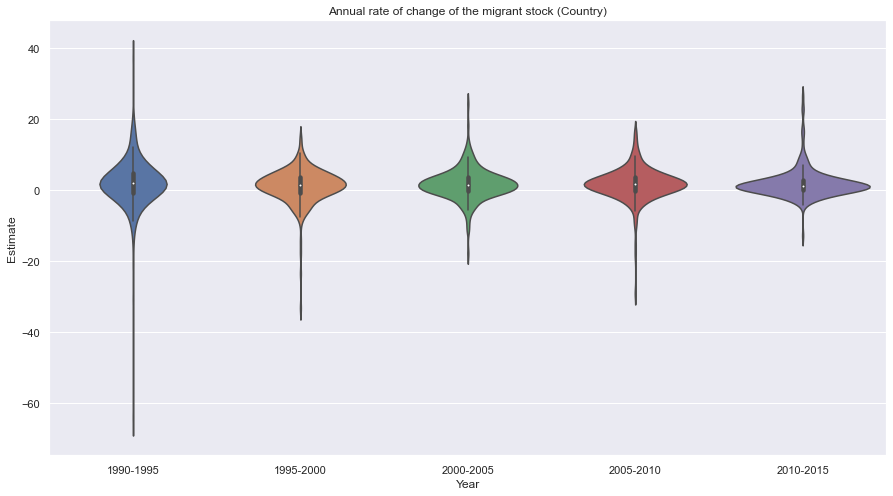

In [359]:
df = by_rate[by_rate['Statistic'] == 'Annual rate of change of the migrant stock']
df = df[df['Sex'] == 'both']
df = df.drop(columns=["Country code", "Statistic", "Table", "Classification", "Sex"])
sns.violinplot('Year', 'Estimate', data=df).set_title("Annual rate of change of the migrant stock (Country)")

In [340]:
new = by_rate[by_rate['Statistic'] == 'Annual rate of change of the migrant stock']
new = new[new['Sex'] == 'both']
new = new.drop(columns=["Country code", "Statistic", "Table", "Classification", "Sex"])
new.sort_values(by='Estimate', ascending=True)
# sns.boxplot('Year', 'Estimate', data=df).set_title("Migrant Rate of Change")

Year  Estimate Major area, region, country or area of destination
440   1990-1995    -63.97                                            Somalia
4241  1995-2000    -33.17                                           Honduras
300   1990-1995    -30.81                                             Malawi
3723  2005-2010    -29.13                   Bonaire, Sint Eustatius and Saba
4221  1995-2000    -23.55                                          Guatemala
...         ...       ...                                                ...
2264  2010-2015     22.07                                               Iraq
464   2010-2015     23.23                                        South Sudan
642   2000-2005     24.23                                               Chad
1964  2010-2015     26.38                                        Afghanistan
3300  1990-1995     36.96                                             Serbia

[1160 rows x 3 columns]

Text(0.5, 1.0, 'Annual rate of change of the migrant stock (Country)')

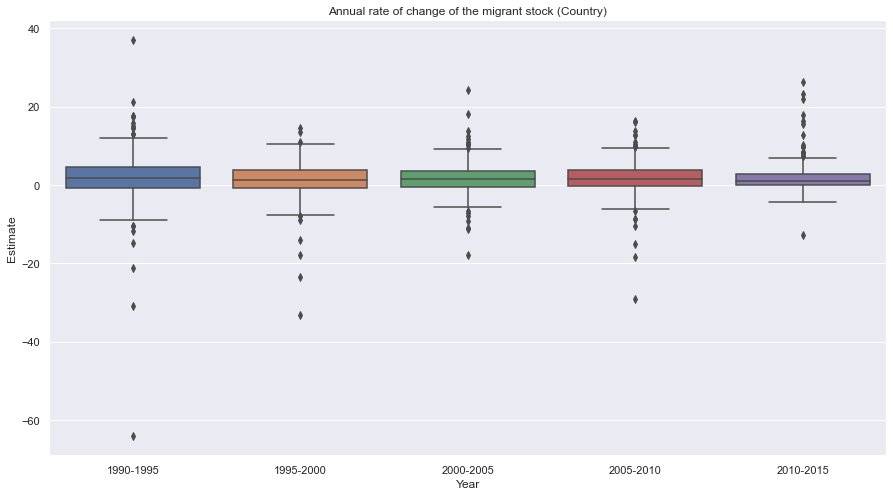

In [358]:
df = by_rate[by_rate['Statistic'] == 'Annual rate of change of the migrant stock']
df = df[df['Sex'] == 'both']
df = df.drop(columns=["Country code", "Statistic", "Table", "Classification", "Sex"])
sns.boxplot('Year', 'Estimate', data=df).set_title("Annual rate of change of the migrant stock (Country)")

In [331]:
df.groupby(by=["Year", "Major area, region, country or area of destination"]).mean()

Estimate
Year      Major area, region, country or area of destination          
1990-1995 Afghanistan                                             4.30
          Albania                                                 1.56
          Algeria                                                -0.89
          American Samoa                                          1.64
          Andorra                                                 0.82
...                                                                ...
2010-2015 Wallis and Futuna Islands                               0.52
          Western Sahara                                          2.84
          Yemen                                                   3.71
          Zambia                                                 -3.14
          Zimbabwe                                                0.05

[1160 rows x 1 columns]

In [333]:
new = df.groupby(level=["Year", "Major area, region, country or area of destination"]).mean()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))
# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=new, palette="Set3", bw=.2, cut=1, linewidth=1)

# Finalize the figure
ax.set(ylim=(-.7, 1.05))
sns.despine(left=True, bottom=True)

ValueError: multiple levels only valid with MultiIndex

In [328]:
df

Year  Estimate Major area, region, country or area of destination
160   1990-1995     -5.36                                            Burundi
161   1995-2000    -14.15                                            Burundi
162   2000-2005      6.38                                            Burundi
163   2005-2010      6.16                                            Burundi
164   2010-2015      3.96                                            Burundi
...         ...       ...                                                ...
5280  1990-1995      3.62                          Wallis and Futuna Islands
5281  1995-2000      3.64                          Wallis and Futuna Islands
5282  2000-2005      3.20                          Wallis and Futuna Islands
5283  2005-2010      3.20                          Wallis and Futuna Islands
5284  2010-2015      0.52                          Wallis and Futuna Islands

[1160 rows x 3 columns]

In [357]:
df[df['Year'] == '1990-1995'].describe()

Estimate
count  232.000000
mean     1.759698
std      7.660339
min    -63.970000
25%     -0.815000
50%      1.890000
75%      4.607500
max     36.960000

In [356]:
df[df['Year'] == '1995-2000'].describe()

Estimate
count  232.000000
mean     1.092284
std      4.928841
min    -33.170000
25%     -0.840000
50%      1.380000
75%      3.750000
max     14.590000

In [354]:
df[df['Year'] == '2000-2005'].describe()

Estimate
count  232.000000
mean     1.698664
std      4.405083
min    -17.830000
25%     -0.397500
50%      1.495000
75%      3.490000
max     24.230000

In [355]:
df[df['Year'] == '2005-2010'].describe()

Estimate
count  232.000000
mean     1.666336
std      4.619727
min    -29.130000
25%     -0.210000
50%      1.620000
75%      3.697500
max     16.260000

In [362]:
print('2010-2015 Descriptive Statistics')
df[df['Year'] == '2010-2015'].describe()

2010-2015 Descriptive Statistics


Estimate
count  232.000000
mean     1.869267
std      4.108592
min    -12.830000
25%     -0.092500
50%      1.080000
75%      2.810000
max     26.380000

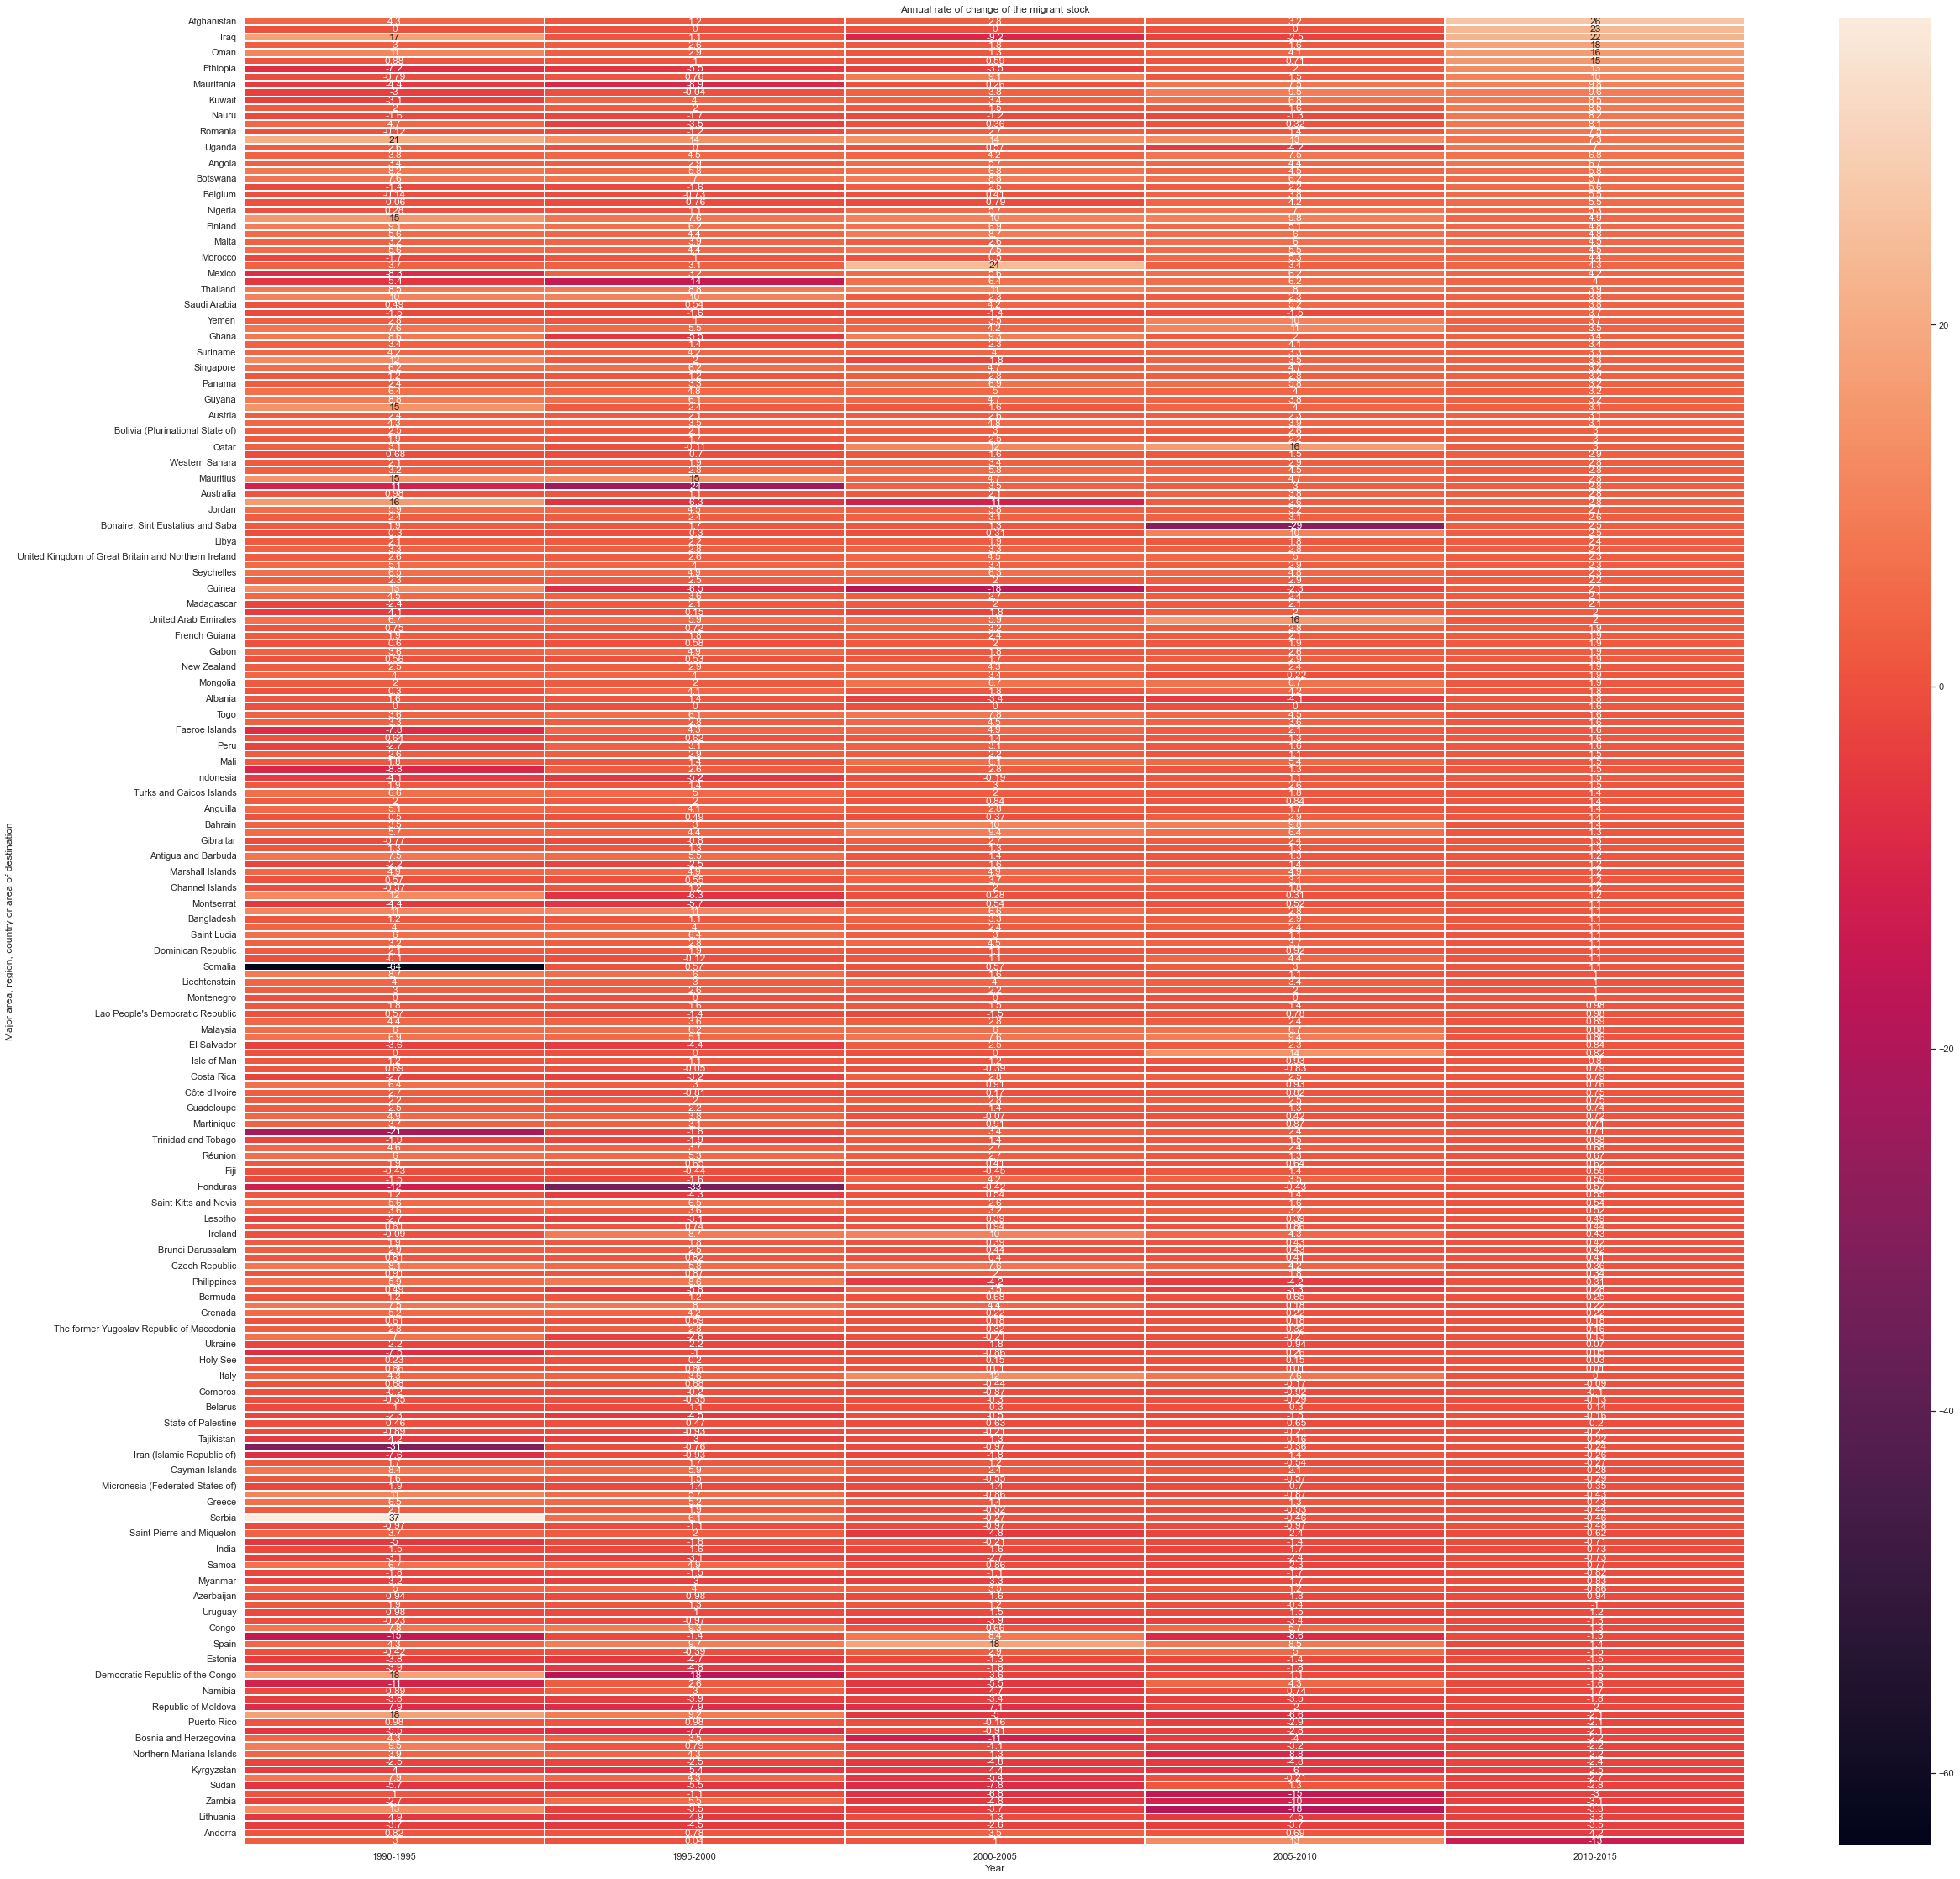

In [352]:
new_migrant = migrant.reset_index()
new_migrant = new_migrant.sort_values(by=['Estimate'], ascending=True)
heatmap1 = new_migrant.pivot("Major area, region, country or area of destination", "Year", "Estimate") 
heatmap1 = heatmap1.sort_values(by=['2010-2015'], ascending=False)
plt.subplots(figsize=(40,40)) 
heatmap = sns.heatmap(heatmap1, linewidths=.1, annot=True).set_title("Annual rate of change of the migrant stock")

In [349]:
heatmap1.sort_values(by=['2010-2015'], ascending=False)

Year                                                1990-1995  1995-2000  \
Major area, region, country or area of destination                         
Afghanistan                                              4.30       1.19   
South Sudan                                              0.00       0.00   
Iraq                                                    17.38       1.08   
Lebanon                                                  3.00       2.60   
Oman                                                    11.48       2.89   
...                                                       ...        ...   
United Republic of Tanzania                             13.12      -3.51   
Lithuania                                               -4.88      -4.88   
Latvia                                                  -3.66      -4.48   
Andorra                                                  0.82       0.78   
Syrian Arab Republic                                     3.02       0.04   

Year                                                2000-2005  2005-2010  \
Major area, region, country or area of destination                         
Afghanistan                                              2.79       3.16   
South Sudan                                              0.00       0.00   
Iraq                                                    -9.20      -2.48   
Lebanon                                                  1.76       1.62   
Oman                                                     1.32       4.06   
...                                                       ...        ...   
United Republic of Tanzania                             -3.71     -18.31   
Lithuania                                               -1.26      -4.49   
Latvia                                                  -2.65      -3.66   
Andorra                                                  3.54       0.69   
Syrian Arab Republic                                     1.03      12.80   

Year                                                2010-2015  
Major area, region, country or area of destination             
Afghanistan                                             26.38  
South Sudan                                             23.23  
Iraq                                                    22.07  
Lebanon                                                 17.79  
Oman                                                    16.31  
...                                                       ...  
United Republic of Tanzania                             -3.33  
Lithuania                                               -3.34  
Latvia                                                  -3.52  
Andorra                                                 -4.25  
Syrian Arab Republic                                   -12.83  

[232 rows x 5 columns]

Text(0.5, 1.0, 'Refugee Rate of Change')

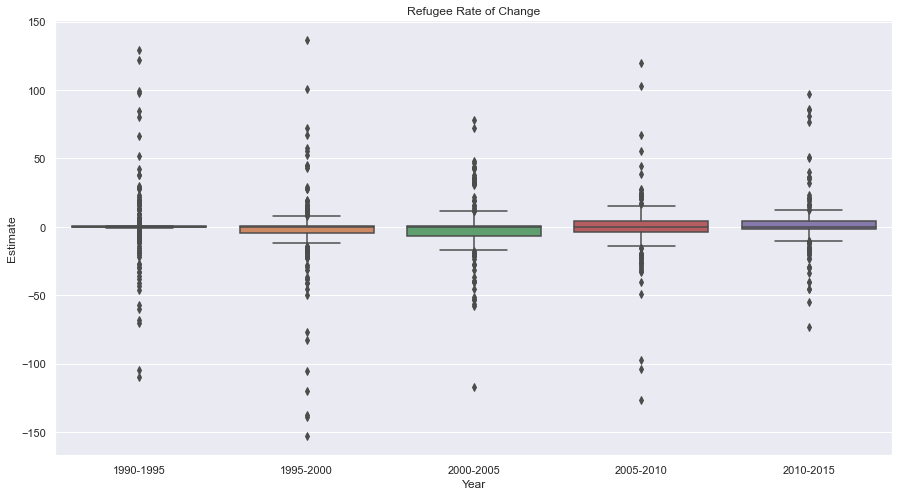

In [266]:
df = by_rate[by_rate['Statistic'] == 'Annual rate of change of the refugee stock']
df = df[df['Sex'] == 'both']
df = df.drop(columns=["Country code", "Statistic", "Table", "Classification", "Sex"])
sns.boxplot('Year', 'Estimate', data=df).set_title("Refugee Rate of Change")

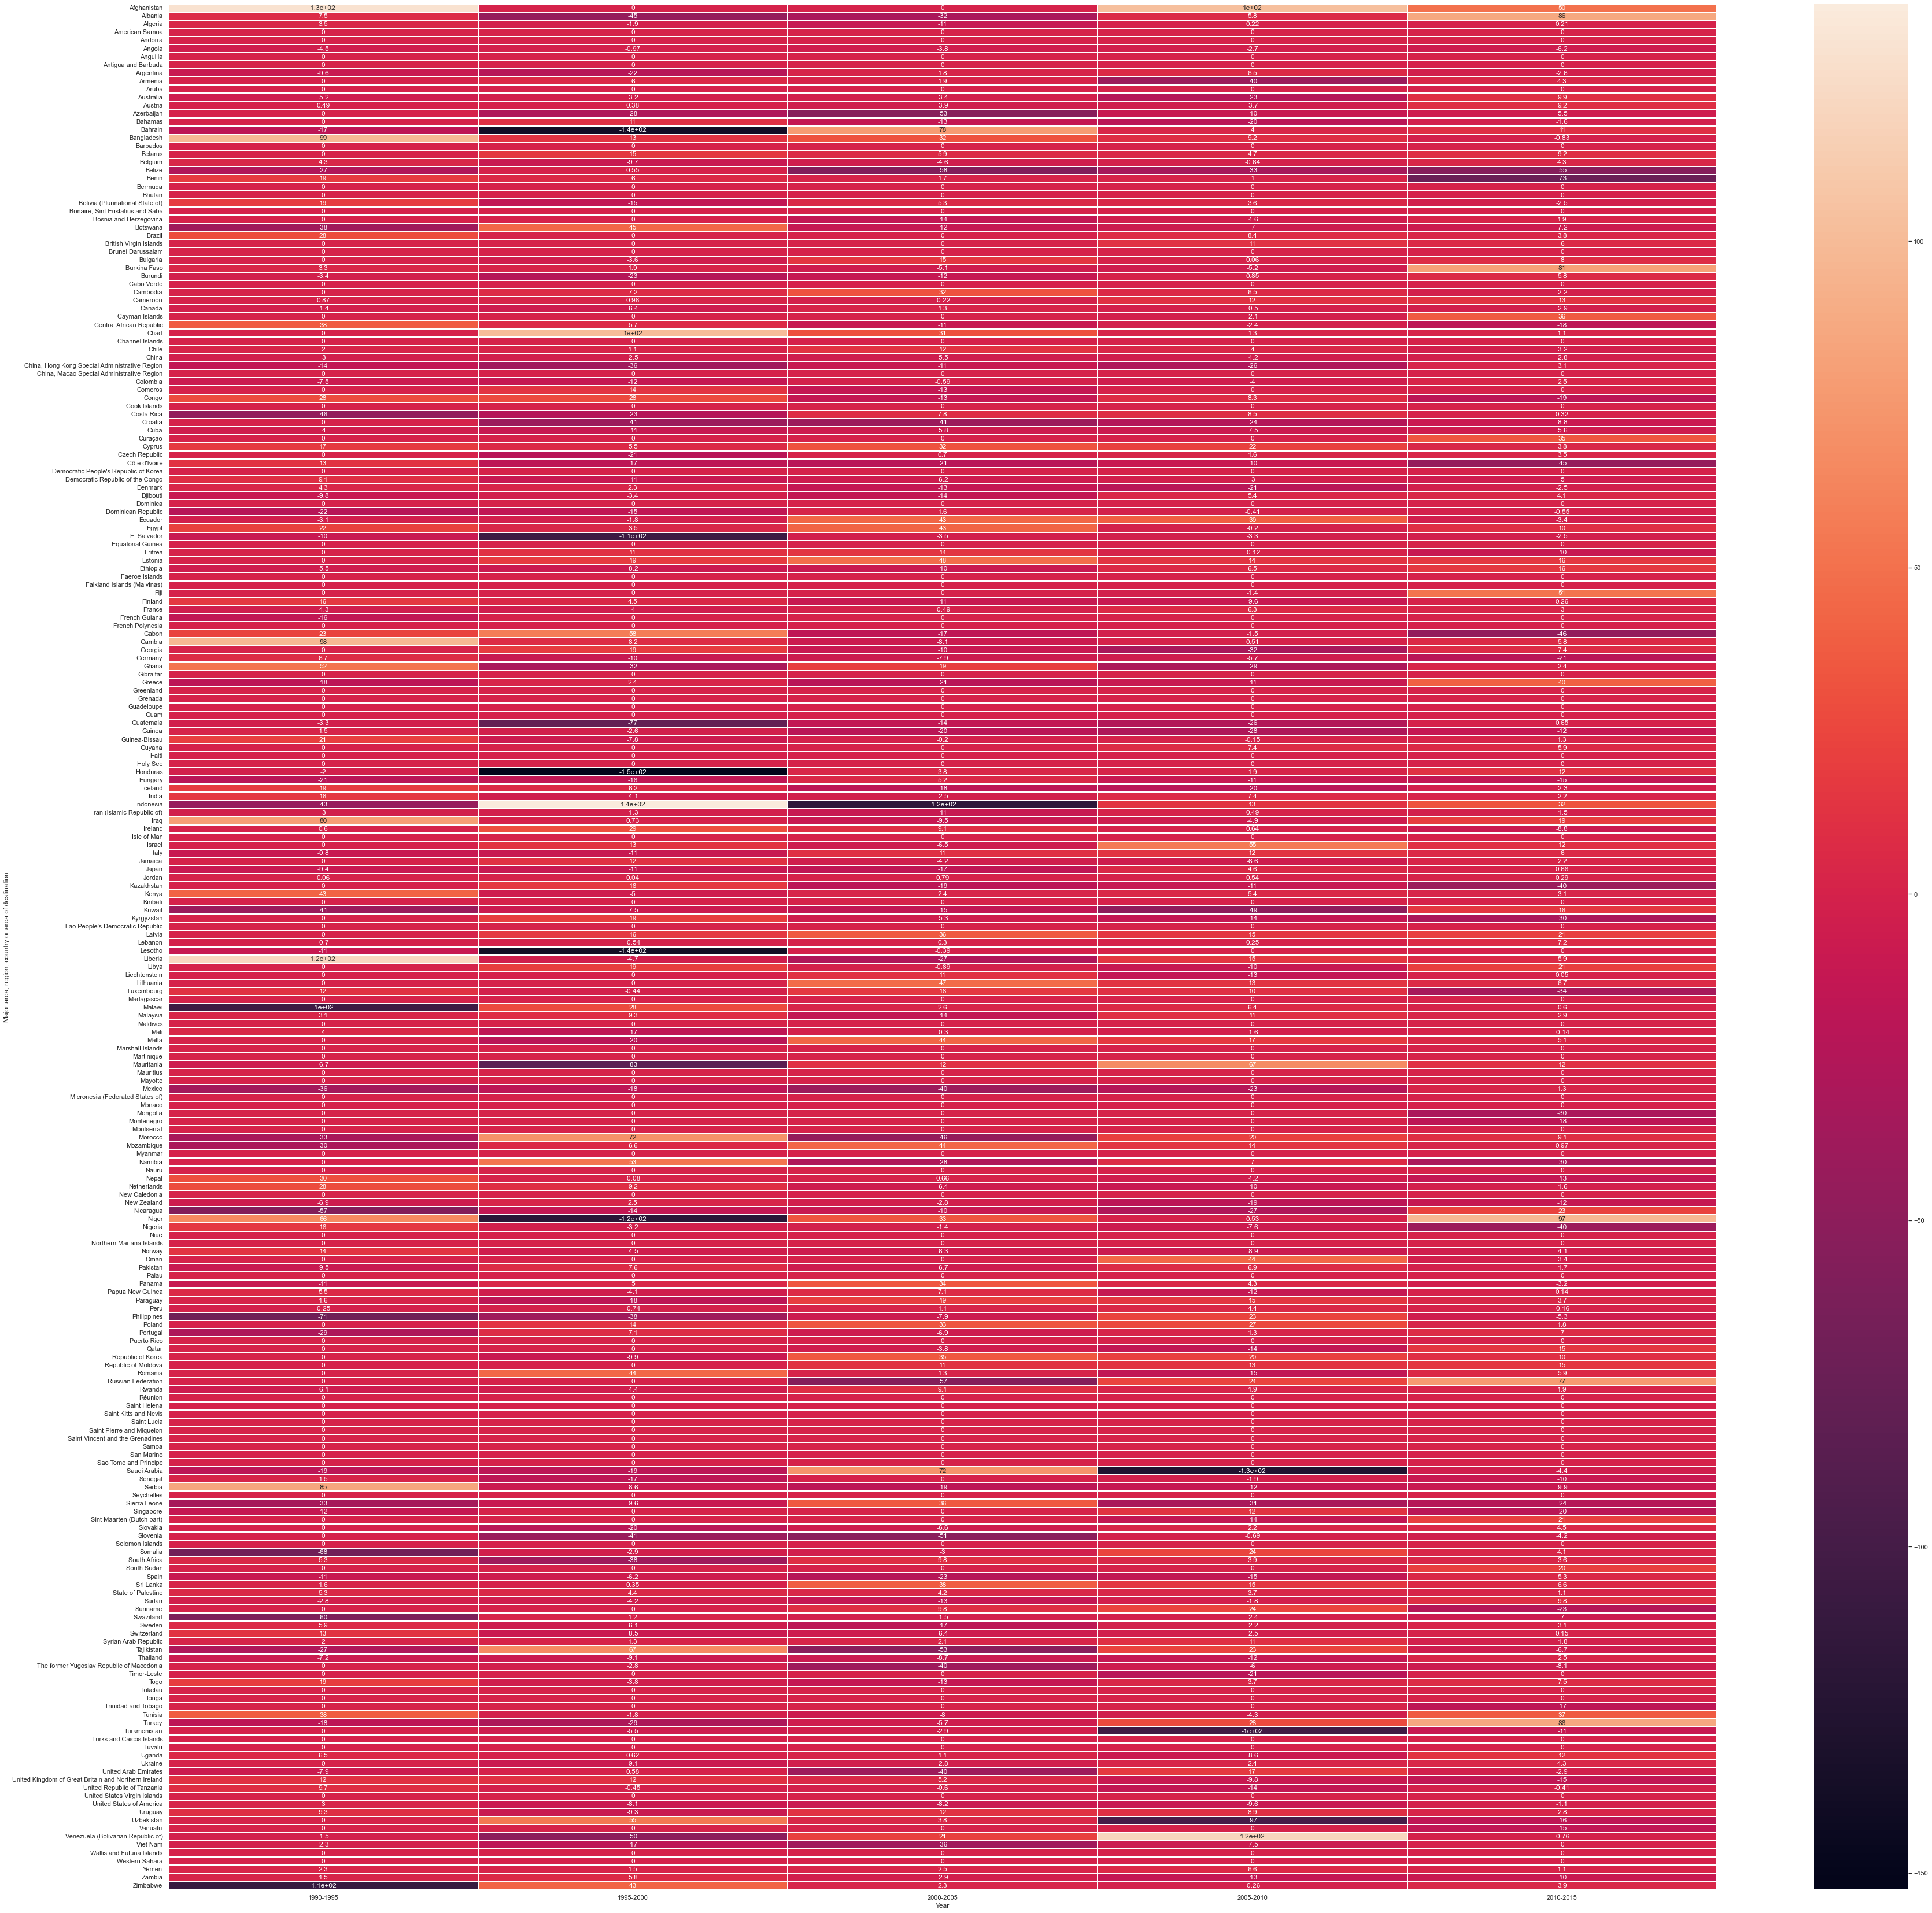

In [304]:
new_refugee = refugee.reset_index()
heatmap2 = new_refugee.pivot("Major area, region, country or area of destination", "Year", "Estimate") 
plt.subplots(figsize=(60,60)) 
heatmap = sns.heatmap(heatmap2, linewidths=.1, annot=True)

## Major area

In [287]:
ma_rate = df_r[df_r['Classification'] == 'Major area'] #.groupby(['Major area, region, country or area of destination', 'Year', 'Statistic', 'Sex']).sum()
ma_rate = ma_rate.drop(columns=["Country code", "Table", "Classification"])

ma_count = df_c[df_c['Classification'] == 'Major area'] #.groupby(['Major area, region, country or area of destination', 'Year', 'Statistic', 'Sex', 'Classification']).sum()
ma_count = ma_count.drop(columns=["Country code", "Table", "Classification"])

ma_percentage = df_p[df_p['Classification'] == 'Major area'] #.groupby(['Major area, region, country or area of destination', 'Year', 'Statistic', 'Sex', 'Classification']).sum()
ma_percentage = ma_percentage.drop(columns=["Country code", "Table", "Classification"])


In [288]:
df = ma_count[ma_count['Statistic'] == 'International migrant stock at mid-year']
df = df[df['Sex'] == 'both']
df = df.drop(columns=["Statistic", "Sex"])
df

Year  Estimate Major area, region, country or area of destination
252   1990  15690623                                             Africa
253   1995  16352814                                             Africa
254   2000  14800306                                             Africa
255   2005  15191146                                             Africa
256   2010  16840014                                             Africa
257   2015  20649557                                             Africa
2940  1990  48142261                                               Asia
2941  1995  46548225                                               Asia
2942  2000  49340815                                               Asia
2943  2005  53371224                                               Asia
2944  2010  65914319                                               Asia
2945  2015  75081125                                               Asia
5292  1990  49219200                                             Europe
5293  1995  52842663                                             Europe
5294  2000  56271885                                             Europe
5295  2005  64086824                                             Europe
5296  2010  72374755                                             Europe
5297  2015  76145954                                             Europe
7518  1990   7169728                    Latin America and the Caribbean
7519  1995   6694640                    Latin America and the Caribbean
7520  2000   6578428                    Latin America and the Caribbean
7521  2005   7233098                    Latin America and the Caribbean
7522  2010   8238795                    Latin America and the Caribbean
7523  2015   9233989                    Latin America and the Caribbean
9702  1990  27610542                                   Northern America
9703  1995  33341147                                   Northern America
9704  2000  40351848                                   Northern America
9705  2005  45363387                                   Northern America
9706  2010  51220996                                   Northern America
9707  2015  54488725                                   Northern America
9954  1990   4730858                                            Oceania
9955  1995   5022263                                            Oceania
9956  2000   5360027                                            Oceania
9957  2005   6023421                                            Oceania
9958  2010   7125364                                            Oceania
9959  2015   8100886                                            Oceania

In [289]:
data = df.pivot("Year", "Major area, region, country or area of destination", "Estimate")

Text(0.5, 1.0, 'International Migrant Stock (Total) at Mid-year by Major Area')

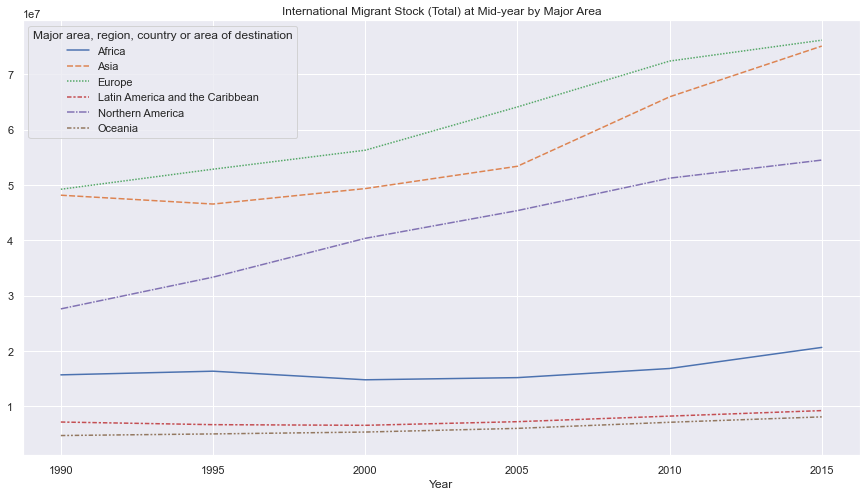

In [307]:
sns.lineplot(data=data).set_title("International Migrant Stock (Total) at Mid-year by Major Area")

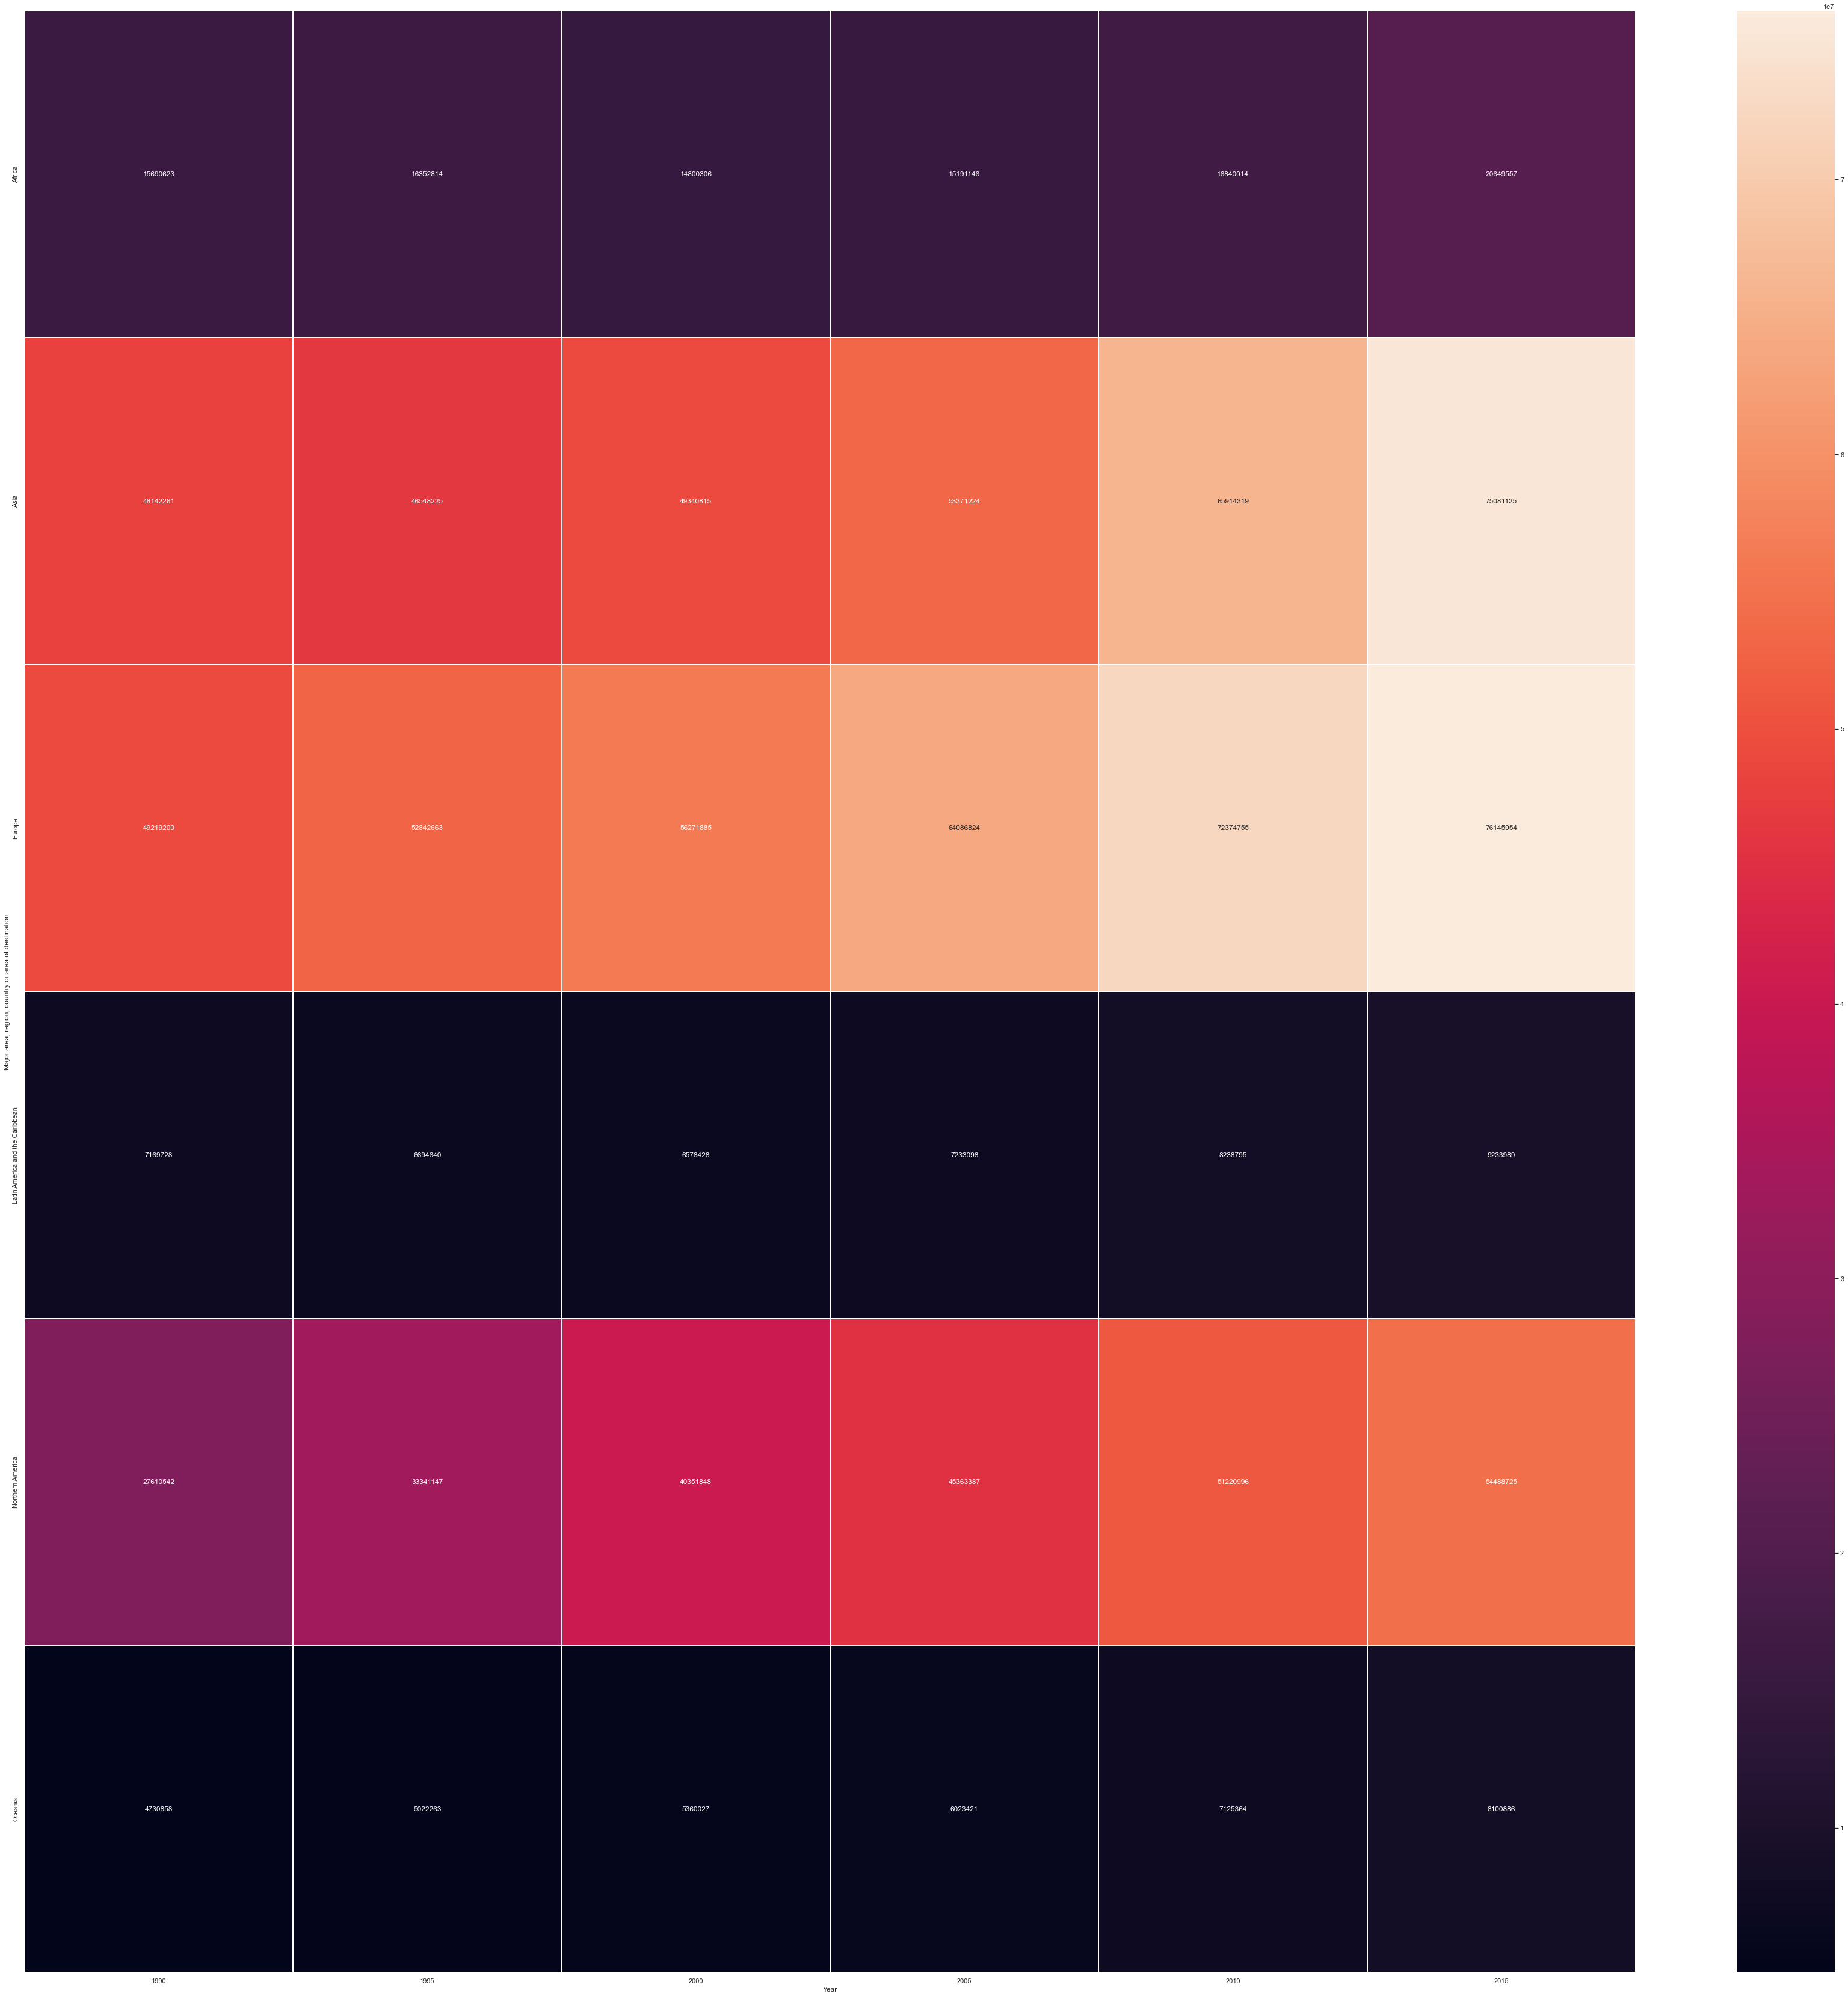

In [293]:
new = df.groupby(by=["Year", "Major area, region, country or area of destination"]).sum()
new = new.reset_index()
heatmap2 = new.pivot("Major area, region, country or area of destination", "Year", "Estimate") 
plt.subplots(figsize=(60,60)) 
heatmap = sns.heatmap(heatmap2, linewidths=.1, annot=True, fmt="d")

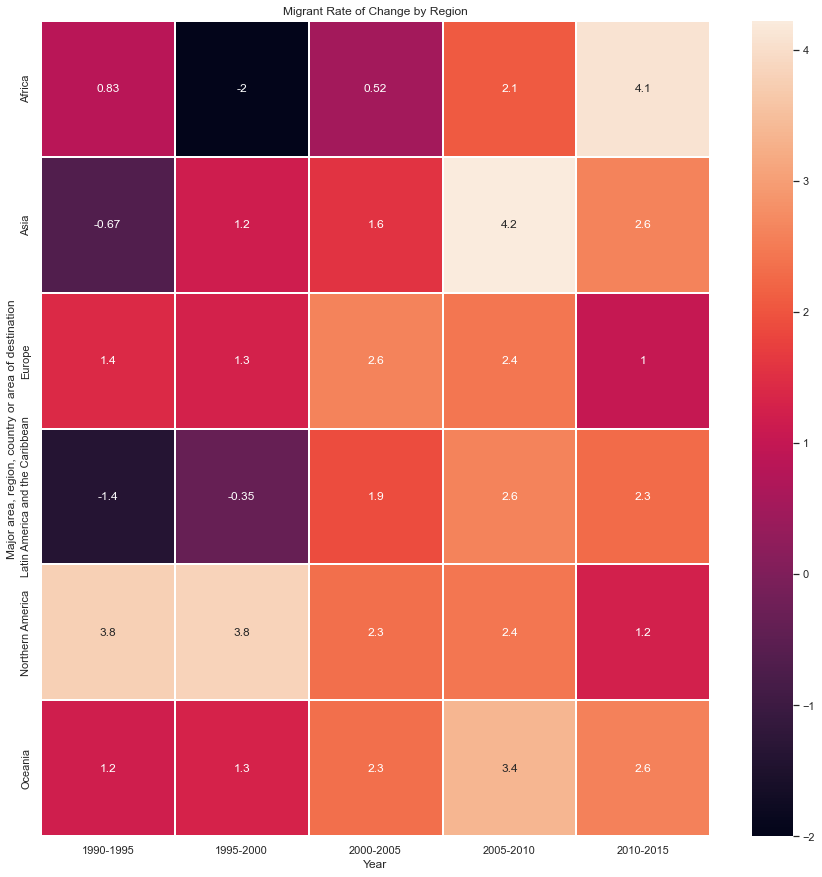

In [306]:
ma = ma_rate[ma_rate['Statistic'] == 'Annual rate of change of the migrant stock']
ma = ma[ma['Sex'] == 'both']
ma = ma.drop(columns=["Statistic", "Sex"])

new_ma = ma.reset_index()
heatmap1 = new_ma.pivot("Major area, region, country or area of destination", "Year", "Estimate") 
plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(heatmap1, linewidths=.1, annot=True).set_title("Migrant Rate of Change by Region")

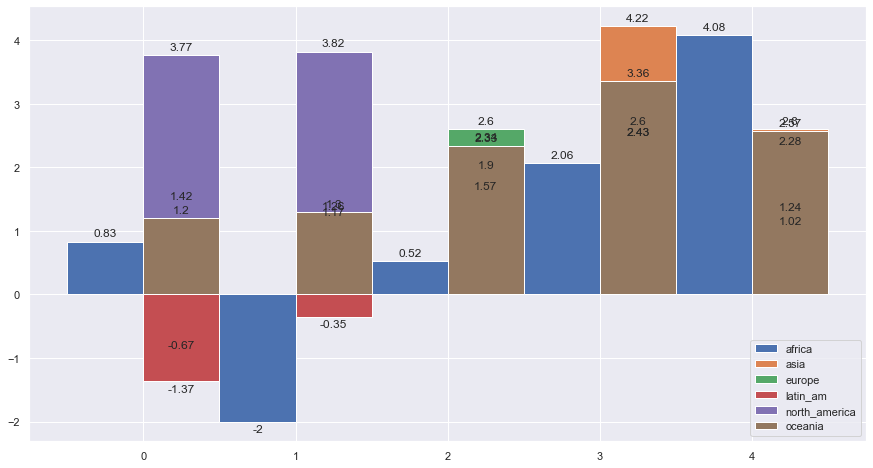

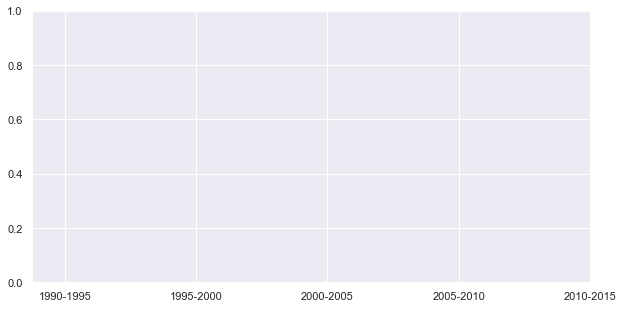

In [558]:
# plot
labels = ['1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015']

africa = [0.83, -2.00, 0.52, 2.06, 4.08]
asia = [-0.67, 1.17, 1.57, 4.22, 2.60]
europe = [1.42, 1.26, 2.60, 2.43, 1.02]
latin_am = [-1.37, -0.35, 1.90, 2.60, 2.28]
north_america = [3.77, 3.82, 2.34, 2.43, 1.24]
oceania = [1.20, 1.30, 2.33, 3.36, 2.57]

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
# Figure size
plt.figure(figsize=(10,5))

rects1 = ax.bar(x - width/2, africa, width, label='africa')
rects2 = ax.bar(x + width/2, asia, width, label='asia')
rects3 = ax.bar(x + width/2, europe, width, label='europe')
rects4 = ax.bar(x + width/2, latin_am, width, label='latin_am')
rects5 = ax.bar(x + width/2, north_america, width, label='north_america')
rects6 = ax.bar(x + width/2, oceania, width, label='oceania')

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
plt.xticks(x + width / 2, ('1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015'))
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)
ax.bar_label(rects5, padding=3)
ax.bar_label(rects6, padding=3)

# fig.tight_layout()

plt.show()

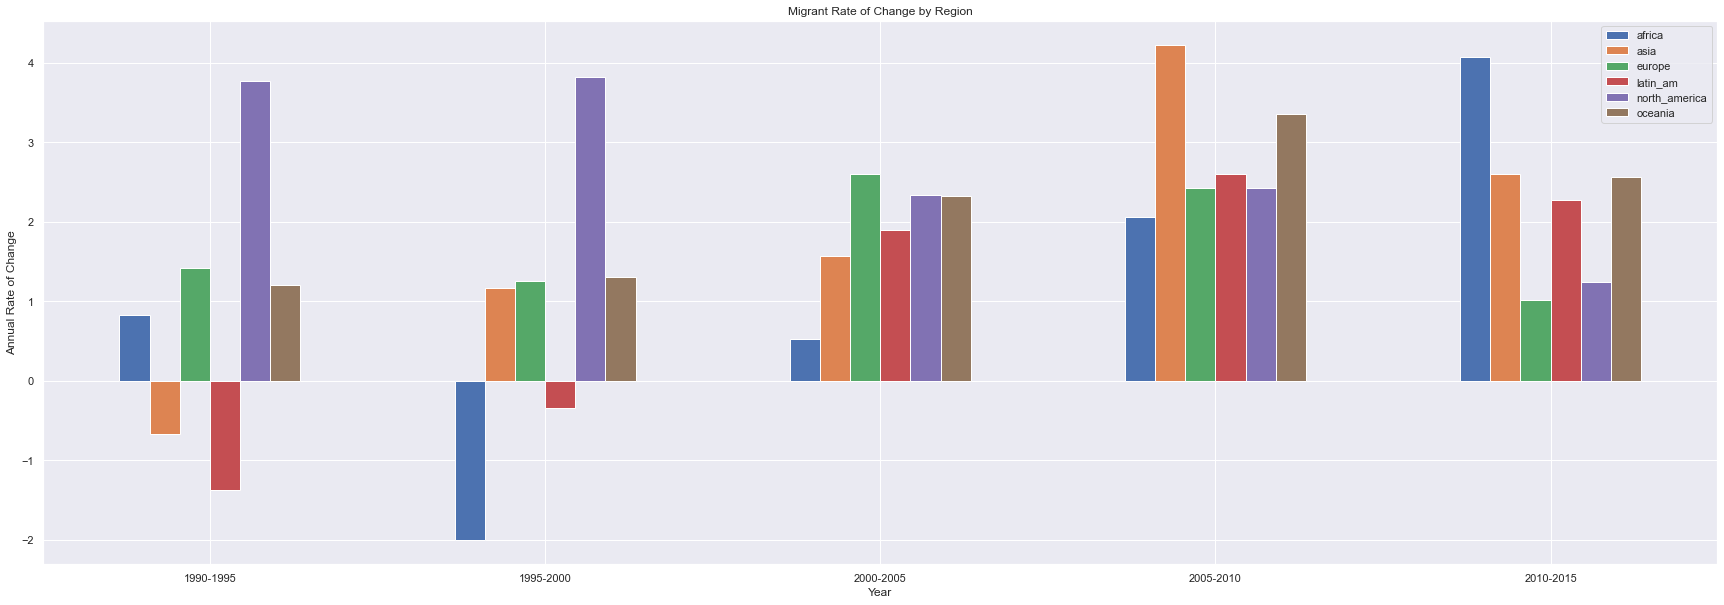

In [581]:
# Numbers of pairs of bars you want
N = 5

# Data on X-axis
africa = [0.83, -2.00, 0.52, 2.06, 4.08]
asia = [-0.67, 1.17, 1.57, 4.22, 2.60]
europe = [1.42, 1.26, 2.60, 2.43, 1.02]
latin_am = [-1.37, -0.35, 1.90, 2.60, 2.28]
north_america = [3.77, 3.82, 2.34, 2.43, 1.24]
oceania = [1.20, 1.30, 2.33, 3.36, 2.57]

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(30,10))

# Width of a bar 
width = 0.09       

# Plotting
plt.bar(ind - (width * 2), africa, width, label='africa')
plt.bar(ind - width, asia, width, label='asia')
plt.bar(ind, europe, width, label='europe')
plt.bar(ind + width, latin_am, width, label='latin_am')
plt.bar(ind + (width*2), north_america, width, label='north_america')
plt.bar(ind + (width*3), oceania, width, label='oceania')

plt.xlabel('Year')
plt.ylabel('Annual Rate of Change')
plt.title('Migrant Rate of Change by Region')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

In [537]:
new_ma.sort_values(by=['Year'], ascending=True)

index       Year  Estimate  \
0     120  1990-1995      0.83   
20   4620  1990-1995      3.77   
25   4740  1990-1995      1.20   
5    1400  1990-1995     -0.67   
15   3580  1990-1995     -1.37   
10   2520  1990-1995      1.42   
21   4621  1995-2000      3.82   
16   3581  1995-2000     -0.35   
26   4741  1995-2000      1.30   
11   2521  1995-2000      1.26   
6    1401  1995-2000      1.17   
1     121  1995-2000     -2.00   
7    1402  2000-2005      1.57   
22   4622  2000-2005      2.34   
12   2522  2000-2005      2.60   
27   4742  2000-2005      2.33   
17   3582  2000-2005      1.90   
2     122  2000-2005      0.52   
13   2523  2005-2010      2.43   
28   4743  2005-2010      3.36   
18   3583  2005-2010      2.60   
3     123  2005-2010      2.06   
8    1403  2005-2010      4.22   
23   4623  2005-2010      2.43   
14   2524  2010-2015      1.02   
19   3584  2010-2015      2.28   
9    1404  2010-2015      2.60   
4     124  2010-2015      4.08   
24   4624  2010-2015      1.24   
29   4744  2010-2015      2.57   

   Major area, region, country or area of destination  
0                                              Africa  
20                                   Northern America  
25                                            Oceania  
5                                                Asia  
15                    Latin America and the Caribbean  
10                                             Europe  
21                                   Northern America  
16                    Latin America and the Caribbean  
26                                            Oceania  
11                                             Europe  
6                                                Asia  
1                                              Africa  
7                                                Asia  
22                                   Northern America  
12                                             Europe  
27                                            Oceania  
17                    Latin America and the Caribbean  
2                                              Africa  
13                                             Europe  
28                                            Oceania  
18                    Latin America and the Caribbean  
3                                              Africa  
8                                                Asia  
23                                   Northern America  
14                                             Europe  
19                    Latin America and the Caribbean  
9                                                Asia  
4                                              Africa  
24                                   Northern America  
29                                            Oceania

In [312]:
ma

Year  Estimate Major area, region, country or area of destination
120   1990-1995      0.83                                             Africa
121   1995-2000     -2.00                                             Africa
122   2000-2005      0.52                                             Africa
123   2005-2010      2.06                                             Africa
124   2010-2015      4.08                                             Africa
1400  1990-1995     -0.67                                               Asia
1401  1995-2000      1.17                                               Asia
1402  2000-2005      1.57                                               Asia
1403  2005-2010      4.22                                               Asia
1404  2010-2015      2.60                                               Asia
2520  1990-1995      1.42                                             Europe
2521  1995-2000      1.26                                             Europe
2522  2000-2005      2.60                                             Europe
2523  2005-2010      2.43                                             Europe
2524  2010-2015      1.02                                             Europe
3580  1990-1995     -1.37                    Latin America and the Caribbean
3581  1995-2000     -0.35                    Latin America and the Caribbean
3582  2000-2005      1.90                    Latin America and the Caribbean
3583  2005-2010      2.60                    Latin America and the Caribbean
3584  2010-2015      2.28                    Latin America and the Caribbean
4620  1990-1995      3.77                                   Northern America
4621  1995-2000      3.82                                   Northern America
4622  2000-2005      2.34                                   Northern America
4623  2005-2010      2.43                                   Northern America
4624  2010-2015      1.24                                   Northern America
4740  1990-1995      1.20                                            Oceania
4741  1995-2000      1.30                                            Oceania
4742  2000-2005      2.33                                            Oceania
4743  2005-2010      3.36                                            Oceania
4744  2010-2015      2.57                                            Oceania

Text(0.5, 1.0, 'Migrant Rate of Change by Region')

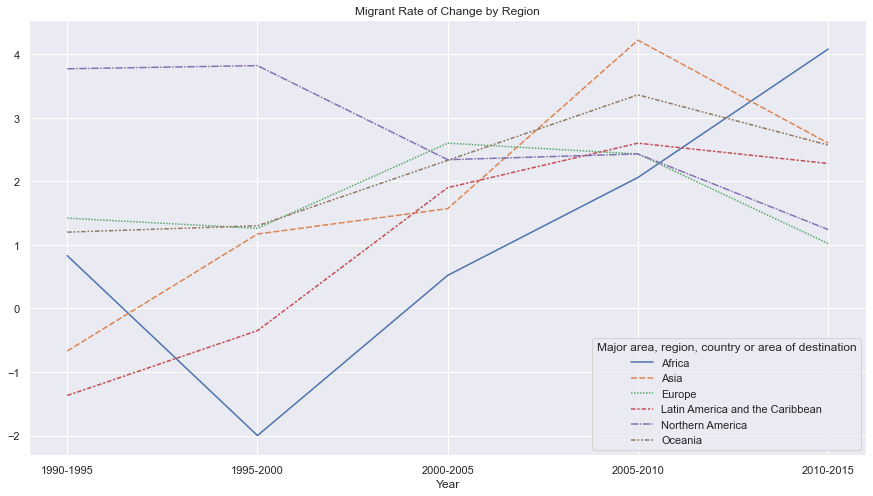

In [311]:
line1 = new_ma.pivot("Year", "Major area, region, country or area of destination", "Estimate") 
sns.lineplot(data=line1).set_title("Migrant Rate of Change by Region")

## Percentage
df_p (percentage): Percentage of total population...
- 'International migrant stock as a percentage of the total population'

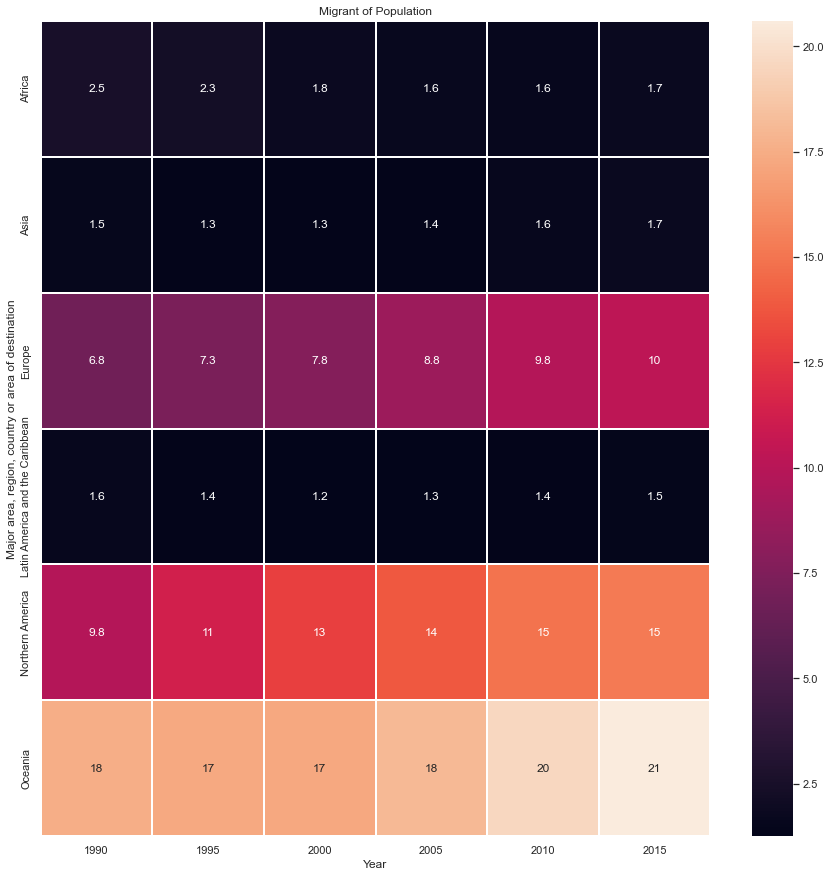

In [316]:
mp = ma_percentage[ma_percentage['Statistic'] == 'International migrant stock as a percentage of the total population']
mp = mp[mp['Sex'] == 'both']
mp = mp.drop(columns=["Statistic", "Sex"])

new_mp = mp.reset_index()
heatmap1 = new_mp.pivot("Major area, region, country or area of destination", "Year", "Estimate") 
plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(heatmap1, linewidths=.1, annot=True).set_title("Migrant of Population")

Text(0.5, 1.0, 'International migrant stock as a percentage of the total population')

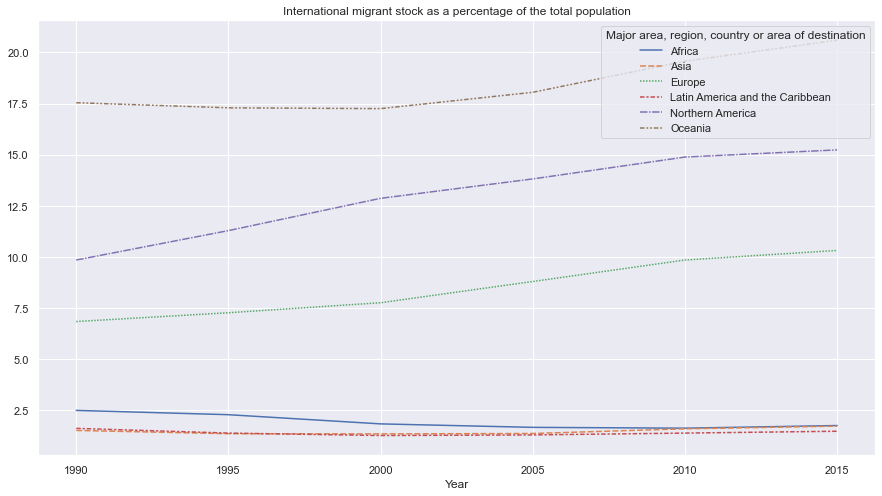

In [318]:
line2 = new_mp.pivot("Year", "Major area, region, country or area of destination", "Estimate") 
sns.lineplot(data=line2).set_title("International migrant stock as a percentage of the total population")

## 2010-2015
- Countries above the "maximum"

In [367]:
new_migrant[new_migrant['Year'] == '2010-2015'].describe()

Estimate
count  232.000000
mean     1.869267
std      4.108592
min    -12.830000
25%     -0.092500
50%      1.080000
75%      2.810000
max     26.380000

In [459]:
outliers = 2.81 + (1.5 * (2.81 - -0.0925))
outliers

7.16375

In [460]:
test = new_migrant.loc[(new_migrant['Year'] == '2010-2015') & (new_migrant['Estimate'] > 7.16375)]
listc = test['Major area, region, country or area of destination'].unique().tolist()
len(listc)


16

In [503]:
above_migrant = new_migrant[new_migrant['Major area, region, country or area of destination'].isin(listc)]
above_migrant.columns = ['Year', 'Major area, region, country or area of destination', 'Migrant Rate of Change']
above_migrant = above_migrant.sort_values(by=['Major area, region, country or area of destination'], ascending=True)
above_migrant

Year Major area, region, country or area of destination  \
928   2010-2015                                        Afghanistan   
0     1990-1995                                        Afghanistan   
696   2005-2010                                        Afghanistan   
464   2000-2005                                        Afghanistan   
232   1995-2000                                        Afghanistan   
...         ...                                                ...   
1139  2010-2015                                             Turkey   
211   1990-1995                                             Turkey   
443   1995-2000                                             Turkey   
675   2000-2005                                             Turkey   
907   2005-2010                                             Turkey   

      Migrant Rate of Change  
928                    26.38  
0                       4.30  
696                     3.16  
464                     2.79  
232                     1.19  
...                      ...  
1139                   15.48  
211                     0.88  
443                     1.04  
675                     0.59  
907                     0.71  

[80 rows x 3 columns]

In [462]:
melt_migrant = pd.melt(above_migrant, id_vars=['Year', 'Major area, region, country or area of destination'], value_vars=['Migrant Rate of Change'], var_name='Statistic', value_name='Estimate', ignore_index=False)
melt_migrant

Year Major area, region, country or area of destination  \
564   2000-2005                                               Iraq   
362   1995-2000                                         Mauritania   
69    1990-1995                                           Ethiopia   
301   1995-2000                                           Ethiopia   
130   1990-1995                                         Mauritania   
...         ...                                                ...   
1043  2010-2015                                            Lebanon   
166   1990-1995                                  Republic of Korea   
1028  2010-2015                                               Iraq   
1120  2010-2015                                        South Sudan   
928   2010-2015                                        Afghanistan   

                   Statistic  Estimate  
564   Migrant Rate of Change     -9.20  
362   Migrant Rate of Change     -8.91  
69    Migrant Rate of Change     -7.18  
301   Migrant Rate of Change     -5.55  
130   Migrant Rate of Change     -4.41  
...                      ...       ...  
1043  Migrant Rate of Change     17.79  
166   Migrant Rate of Change     21.16  
1028  Migrant Rate of Change     22.07  
1120  Migrant Rate of Change     23.23  
928   Migrant Rate of Change     26.38  

[80 rows x 4 columns]

In [463]:
above_migrant.groupby(by=["Year", "Major area, region, country or area of destination"]).sum()

Migrant Rate of Change
Year      Major area, region, country or area of destination                        
1990-1995 Afghanistan                                                           4.30
          Egypt                                                                -0.79
          Ethiopia                                                             -7.18
          Iraq                                                                 17.38
          Kuwait                                                               -3.06
...                                                                              ...
2010-2015 Republic of Korea                                                     7.35
          Romania                                                               7.50
          South Africa                                                          9.61
          South Sudan                                                          23.23
          Turkey                                                               15.48

[80 rows x 1 columns]

Above: Countries whose "Estimate" is above the "maximum" in 2010-2015.

In [464]:
new_refugee = refugee.reset_index()
new_refugee = new_refugee.sort_values(by=['Estimate'], ascending=True)
new_refugee

Year Major area, region, country or area of destination  Estimate
326  1995-2000                                           Honduras   -152.54
247  1995-2000                                            Bahrain   -138.85
348  1995-2000                                            Lesotho   -137.24
876  2005-2010                                       Saudi Arabia   -126.64
381  1995-2000                                              Niger   -119.77
..         ...                                                ...       ...
696  2005-2010                                        Afghanistan    102.91
921  2005-2010                 Venezuela (Bolivarian Republic of)    119.69
117  1990-1995                                            Liberia    121.62
0    1990-1995                                        Afghanistan    128.99
330  1995-2000                                          Indonesia    136.38

[1160 rows x 3 columns]

In [504]:
above_refugee = new_refugee[new_refugee['Major area, region, country or area of destination'].isin(listc)]
above_refugee.columns = ['Year', 'Major area, region, country or area of destination', 'Refugee Rate of Change']
above_refugee = above_refugee.sort_values(by=['Major area, region, country or area of destination'], ascending=True)
above_refugee

Year Major area, region, country or area of destination  \
0     1990-1995                                        Afghanistan   
696   2005-2010                                        Afghanistan   
464   2000-2005                                        Afghanistan   
232   1995-2000                                        Afghanistan   
928   2010-2015                                        Afghanistan   
...         ...                                                ...   
675   2000-2005                                             Turkey   
907   2005-2010                                             Turkey   
211   1990-1995                                             Turkey   
443   1995-2000                                             Turkey   
1139  2010-2015                                             Turkey   

      Refugee Rate of Change  
0                     128.99  
696                   102.91  
464                     0.00  
232                     0.00  
928                    50.50  
...                      ...  
675                    -5.74  
907                    27.90  
211                   -18.21  
443                   -29.44  
1139                   85.80  

[80 rows x 3 columns]

In [466]:
melt_refugee = pd.melt(above_refugee, id_vars=['Year', 'Major area, region, country or area of destination'], value_vars=['Refugee Rate of Change'], var_name='Statistic', value_name='Estimate', ignore_index=False)
melt_refugee

Year Major area, region, country or area of destination  \
381   1995-2000                                              Niger   
362   1995-2000                                         Mauritania   
807   2005-2010                                             Kuwait   
111   1990-1995                                             Kuwait   
423   1995-2000                                       South Africa   
...         ...                                                ...   
100   1990-1995                                               Iraq   
1139  2010-2015                                             Turkey   
1077  2010-2015                                              Niger   
696   2005-2010                                        Afghanistan   
0     1990-1995                                        Afghanistan   

                   Statistic  Estimate  
381   Refugee Rate of Change   -119.77  
362   Refugee Rate of Change    -82.84  
807   Refugee Rate of Change    -49.05  
111   Refugee Rate of Change    -41.05  
423   Refugee Rate of Change    -38.10  
...                      ...       ...  
100   Refugee Rate of Change     79.92  
1139  Refugee Rate of Change     85.80  
1077  Refugee Rate of Change     97.35  
696   Refugee Rate of Change    102.91  
0     Refugee Rate of Change    128.99  

[80 rows x 4 columns]

above_migrant and above_refugee

In [467]:
# above_all = above_migrant.merge(above_refugee, on=['Year', 'Major area, region, country or area of destination'])
above_all = pd.concat([melt_migrant, melt_refugee], axis=0)
above_all = above_all.reset_index(drop=True)
above_all

Year Major area, region, country or area of destination  \
0    2000-2005                                               Iraq   
1    1995-2000                                         Mauritania   
2    1990-1995                                           Ethiopia   
3    1995-2000                                           Ethiopia   
4    1990-1995                                         Mauritania   
..         ...                                                ...   
155  1990-1995                                               Iraq   
156  2010-2015                                             Turkey   
157  2010-2015                                              Niger   
158  2005-2010                                        Afghanistan   
159  1990-1995                                        Afghanistan   

                  Statistic  Estimate  
0    Migrant Rate of Change     -9.20  
1    Migrant Rate of Change     -8.91  
2    Migrant Rate of Change     -7.18  
3    Migrant Rate of Change     -5.55  
4    Migrant Rate of Change     -4.41  
..                      ...       ...  
155  Refugee Rate of Change     79.92  
156  Refugee Rate of Change     85.80  
157  Refugee Rate of Change     97.35  
158  Refugee Rate of Change    102.91  
159  Refugee Rate of Change    128.99  

[160 rows x 4 columns]

In [468]:
above_all.groupby(by=["Year", "Major area, region, country or area of destination", "Statistic"]).sum()

Estimate
Year      Major area, region, country or area of destination Statistic                       
1990-1995 Afghanistan                                        Migrant Rate of Change      4.30
                                                             Refugee Rate of Change    128.99
          Egypt                                              Migrant Rate of Change     -0.79
                                                             Refugee Rate of Change     22.07
          Ethiopia                                           Migrant Rate of Change     -7.18
...                                                                                       ...
2010-2015 South Africa                                       Refugee Rate of Change      3.62
          South Sudan                                        Migrant Rate of Change     23.23
                                                             Refugee Rate of Change     20.39
          Turkey                                             Migrant Rate of Change     15.48
                                                             Refugee Rate of Change     85.80

[160 rows x 1 columns]

In [531]:
rtm = df_p[df_p['Classification'] == 'Country or area']
rtm = rtm[rtm['Statistic'] == 'Refugees as a percentage of the international migrant stock']
rtm = rtm[rtm['Sex'] == 'both']
rtm = rtm[rtm['Major area, region, country or area of destination'].isin(listc)]
rtm = rtm.drop(columns=["Country code", "Statistic", "Table", "Classification", "Sex"])
# rtm = rtm.groupby(by=["Year", "Major area, region, country or area of destination"]).sum()
rtm

Year  Estimate Major area, region, country or area of destination
384   1990     64.22                                           Ethiopia
385   1995     48.76                                           Ethiopia
386   2000     32.38                                           Ethiopia
387   2005     19.60                                           Ethiopia
388   2010     27.18                                           Ethiopia
...    ...       ...                                                ...
7585  1995      0.00                                              Nauru
7586  2000      0.00                                              Nauru
7587  2005      0.00                                              Nauru
7588  2010      0.00                                              Nauru
7589  2015     12.24                                              Nauru

[96 rows x 3 columns]

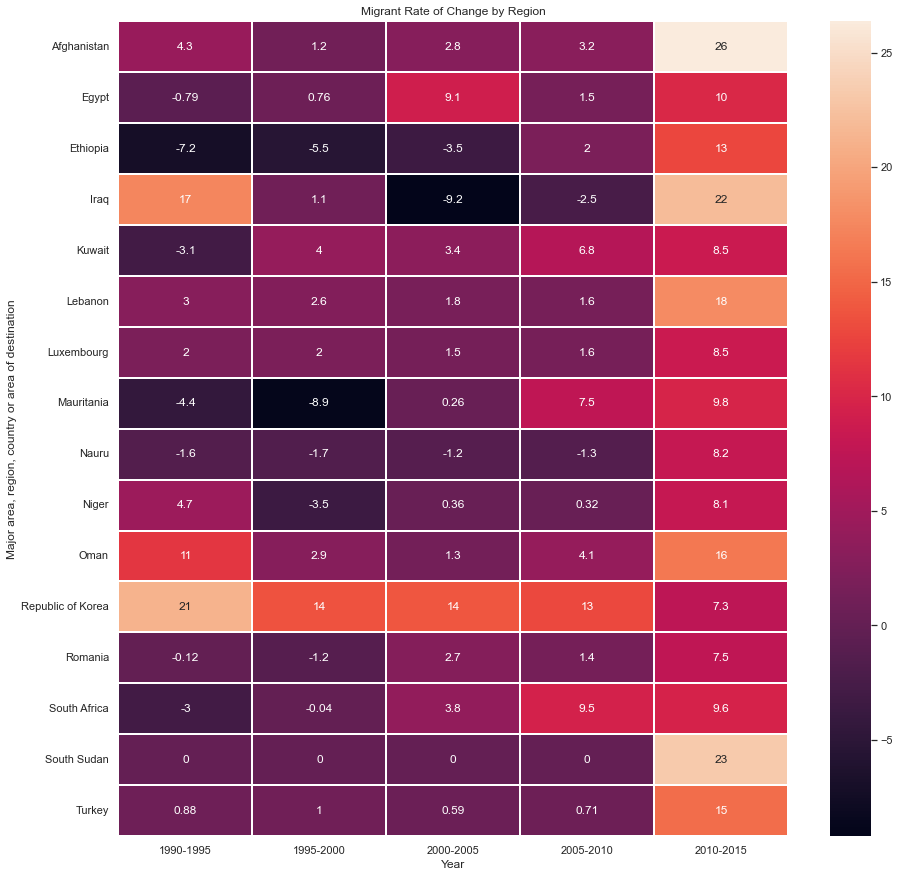

In [473]:
new_m = above_migrant.reset_index()
# new_m = new_m.sort_values(by=["Migrant Rate of Change"], ascending=True)
heatmap1 = new_m.pivot("Major area, region, country or area of destination", "Year", "Migrant Rate of Change") 
# heatmap1 = heatmap1.sort_values(by=['2010-2015'], ascending=False)
plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(heatmap1, linewidths=.1, annot=True).set_title("Migrant Rate of Change by Region")

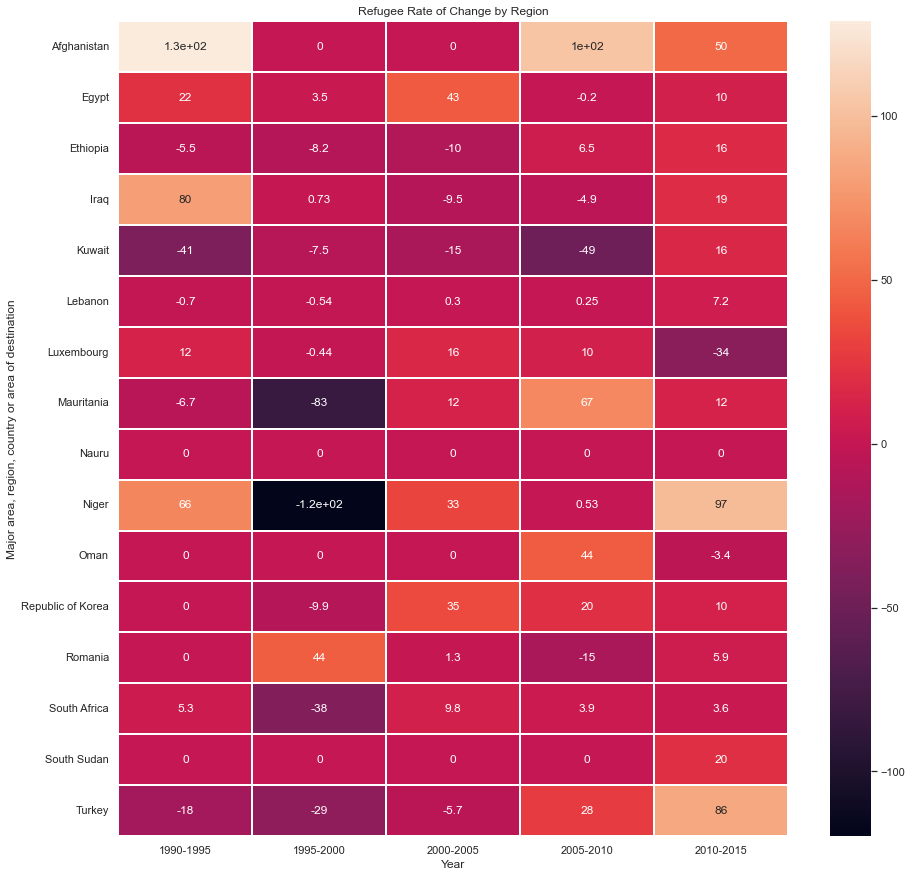

In [471]:
new_r = above_refugee.reset_index()
# new_r = new_r.sort_values(by=["Refugee Rate of Change"], ascending=True)
heatmap1 = new_r.pivot("Major area, region, country or area of destination", "Year", "Refugee Rate of Change") 
# heatmap1 = heatmap1.sort_values(by=['2010-2015'], ascending=False)
plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(heatmap1, linewidths=.1, annot=True).set_title("Refugee Rate of Change by Region")

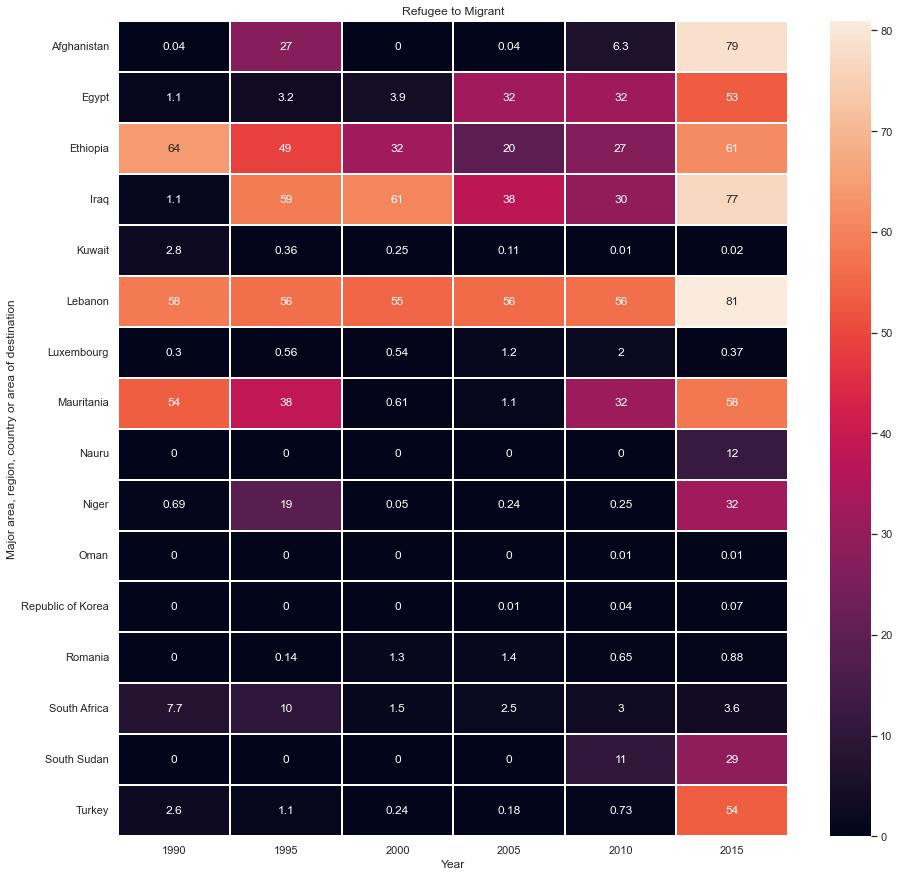

In [472]:
new_rtm = rtm.reset_index()
# new_rtm = new_rtm.sort_values(by=["Estimate"], ascending=True)
heatmap1 = new_rtm.pivot("Major area, region, country or area of destination", "Year", "Estimate") 
# heatmap1 = heatmap1.sort_values(by=['2015'], ascending=False)
plt.subplots(figsize=(15,15)) 
heatmap = sns.heatmap(heatmap1, linewidths=.1, annot=True).set_title("Refugee to Migrant")

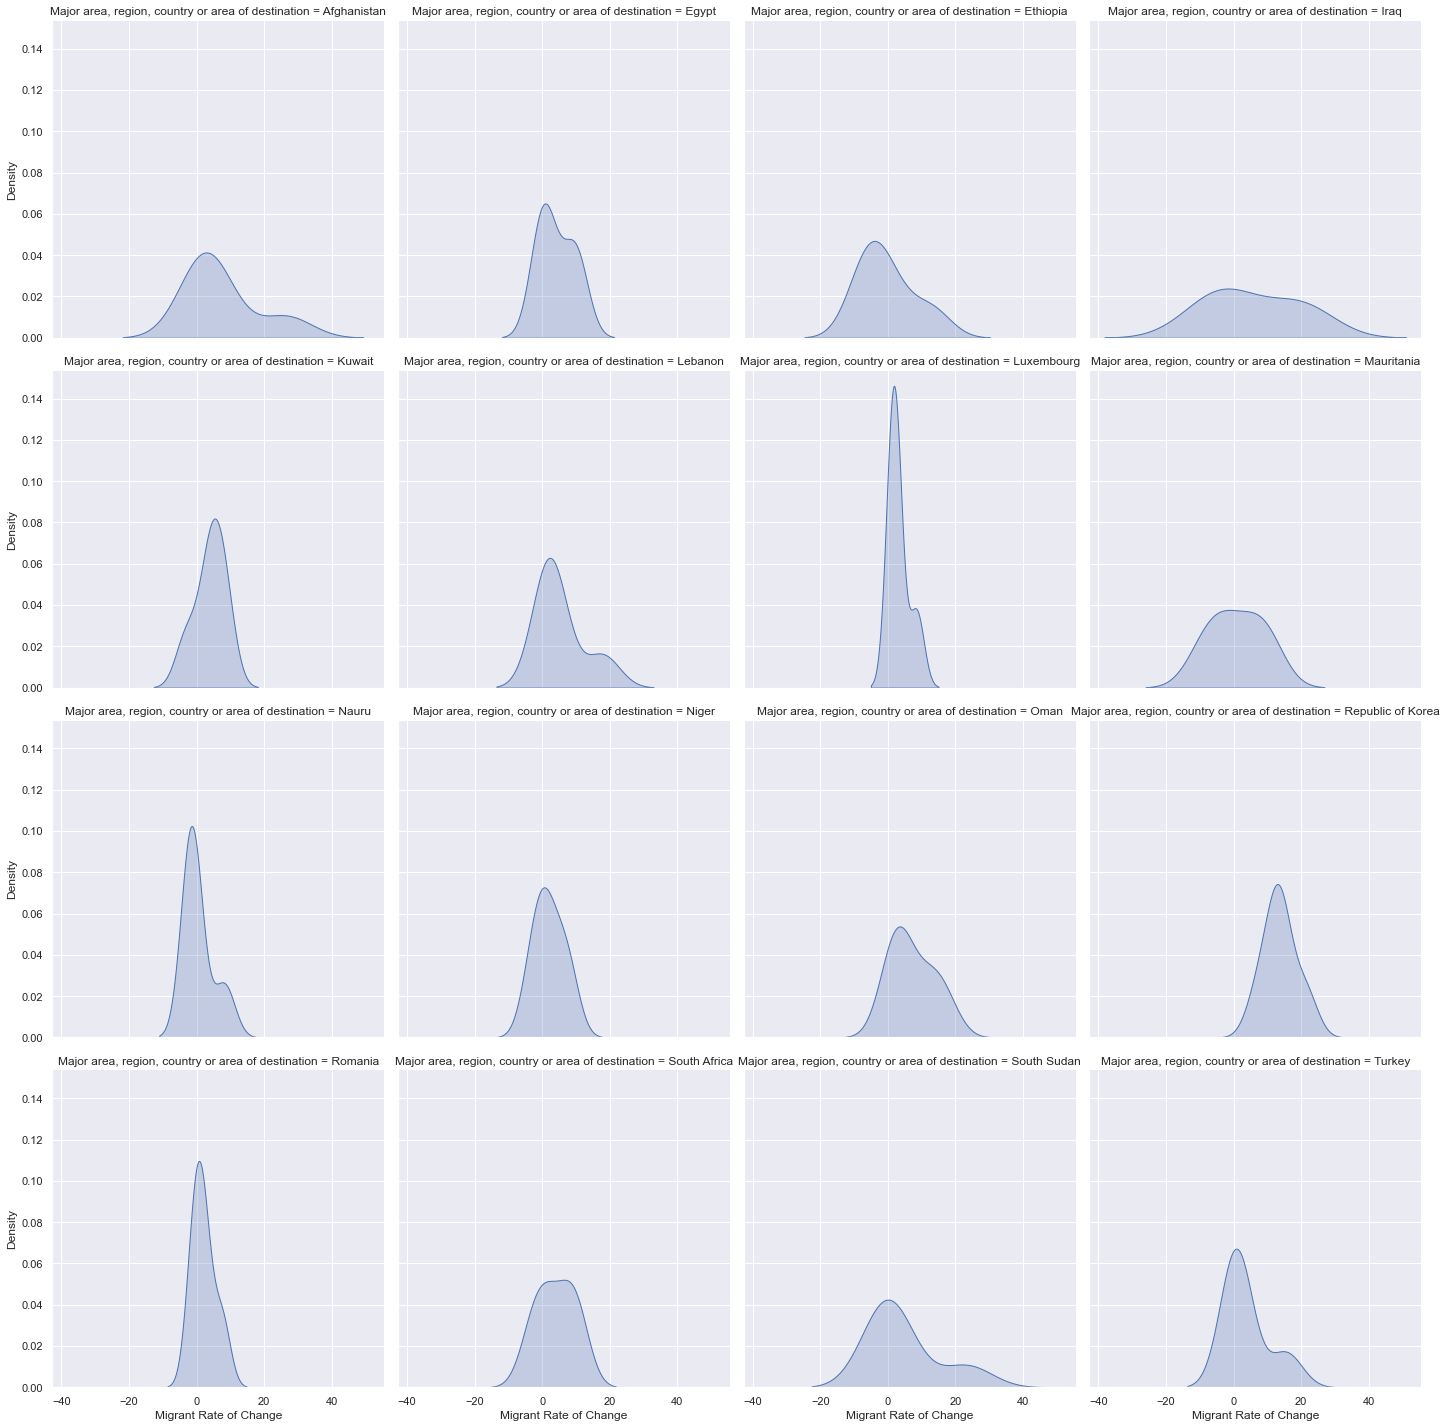

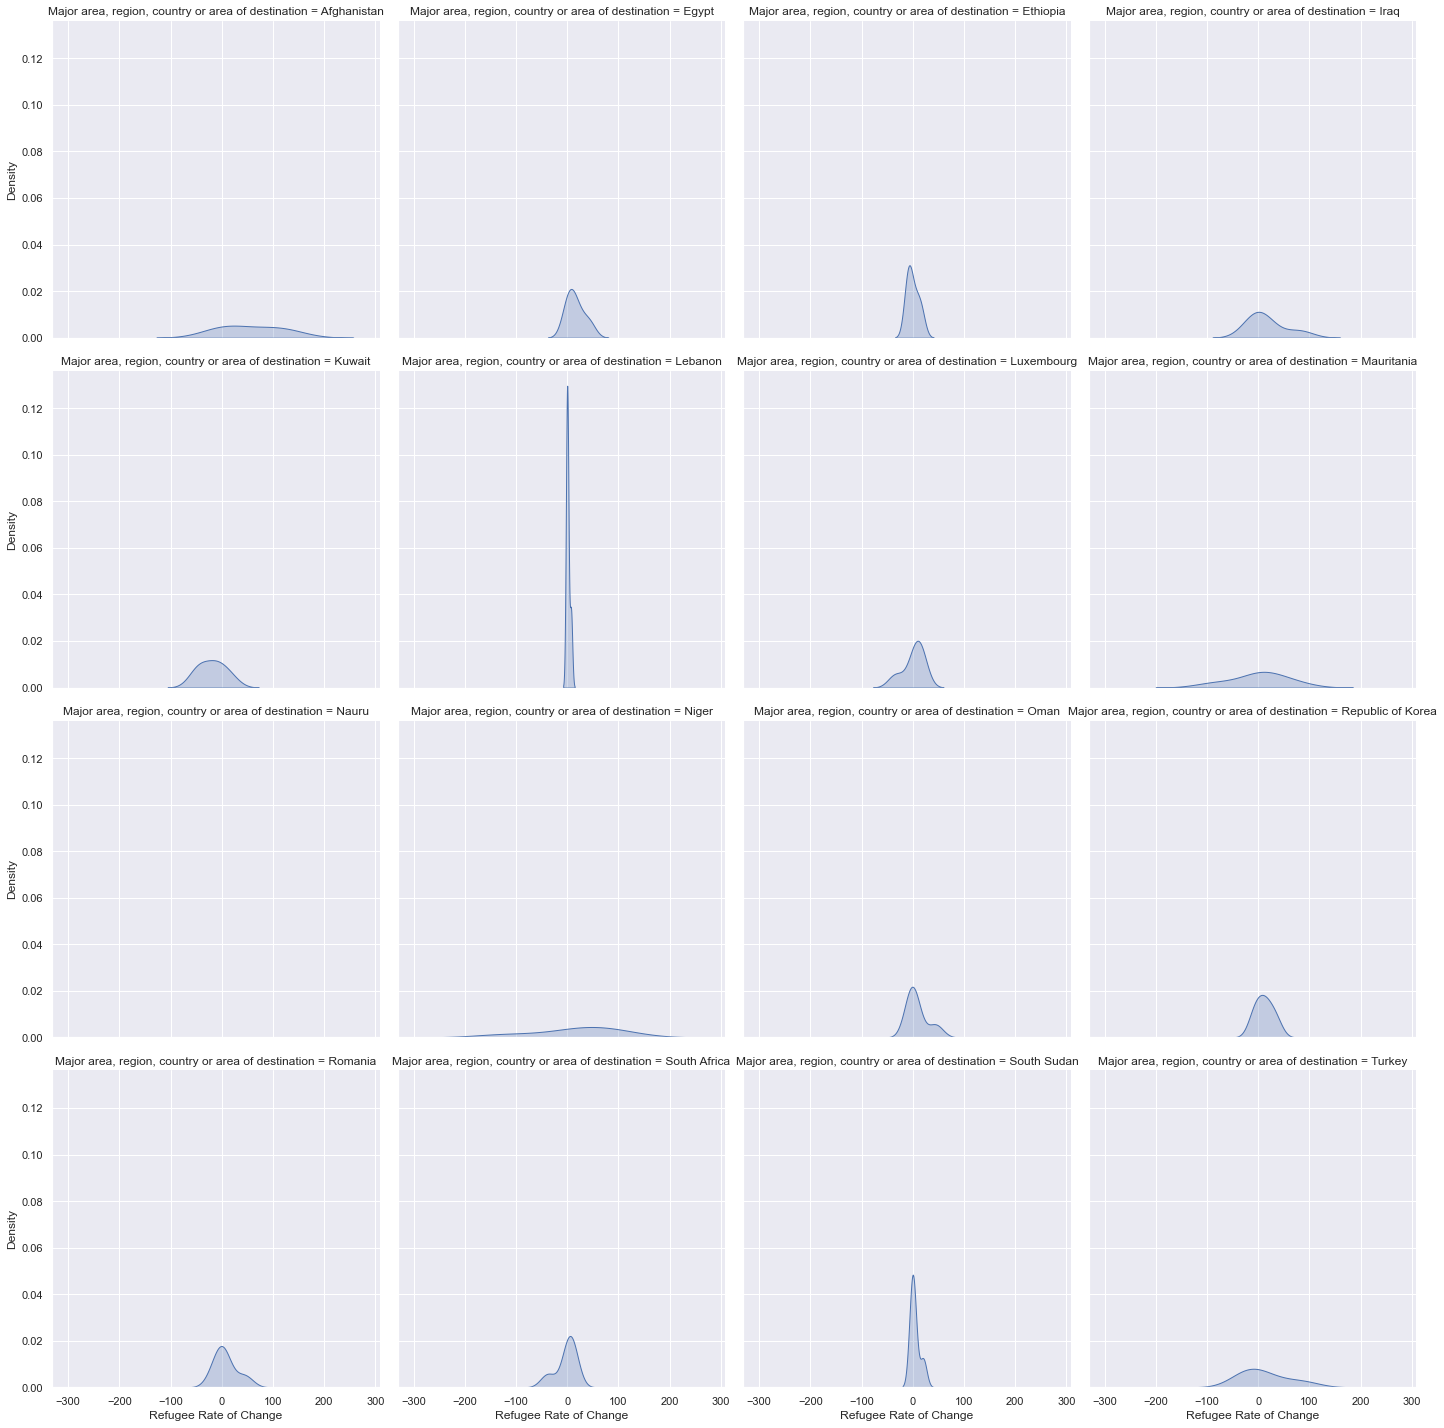

In [510]:
g = sns.FacetGrid(above_migrant, col='Major area, region, country or area of destination', col_wrap=4, size=5)
g = g.map(sns.kdeplot, 'Migrant Rate of Change', shade=True)

k = sns.FacetGrid(above_refugee, col='Major area, region, country or area of destination', col_wrap=4, size=5)
k = k.map(sns.kdeplot, 'Refugee Rate of Change', shade=True)

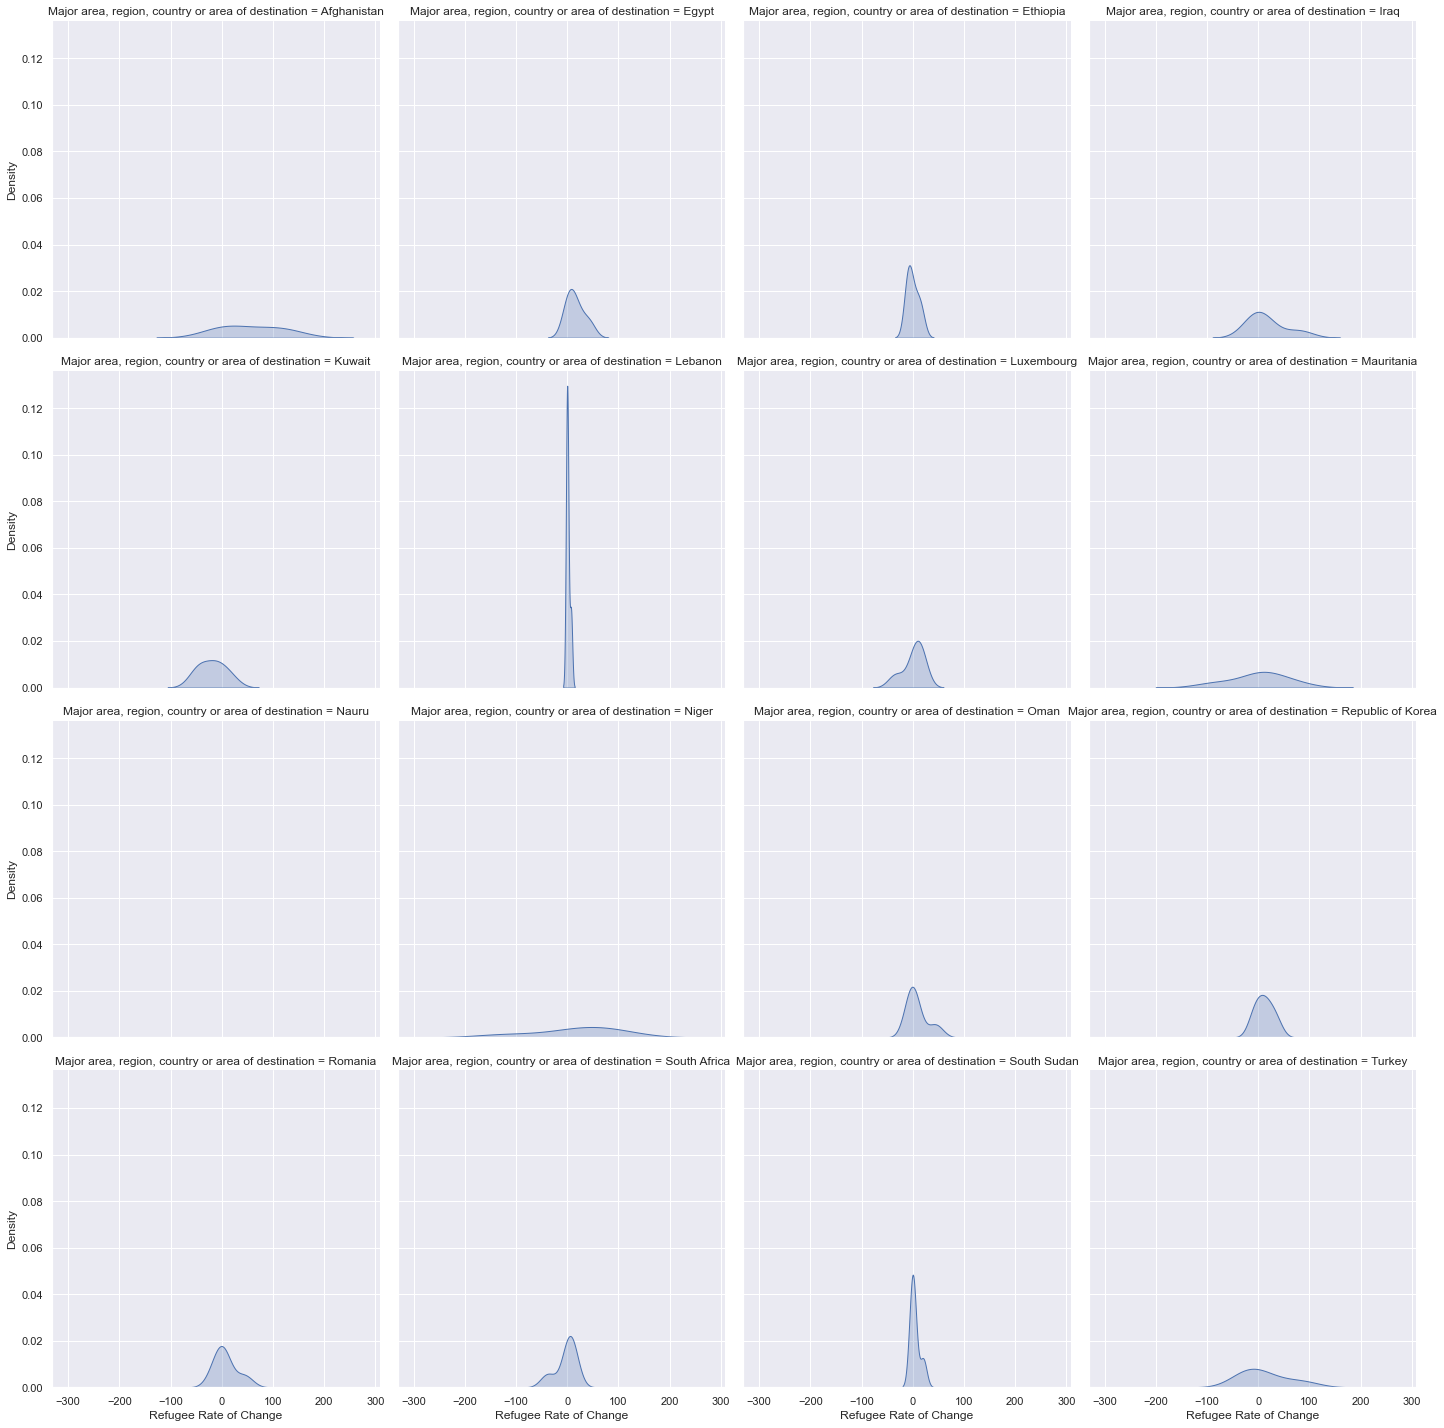

In [508]:
g = sns.FacetGrid(above_refugee, col='Major area, region, country or area of destination', col_wrap=4, size=5)
g = g.map(sns.kdeplot, 'Refugee Rate of Change', shade=True)

In [507]:
sns.kdeplot(above_migrant, color='r', shade=True, Label='Migrant')
  
sns.kdeplot(above_refugee, color='b', shade=True, Label='Refugee')
  
plt.xlabel('Annual rate of change')
plt.ylabel('Probability Density')

ValueError: If using all scalar values, you must pass an index

In [493]:
# sns.pairplot(above_migrant, size=5)
# # 

In [494]:
# sns.pairplot(above_refugee, col= size=2.5)

In [495]:
above_all

Year Major area, region, country or area of destination  \
0    2000-2005                                               Iraq   
1    1995-2000                                         Mauritania   
2    1990-1995                                           Ethiopia   
3    1995-2000                                           Ethiopia   
4    1990-1995                                         Mauritania   
..         ...                                                ...   
155  1990-1995                                               Iraq   
156  2010-2015                                             Turkey   
157  2010-2015                                              Niger   
158  2005-2010                                        Afghanistan   
159  1990-1995                                        Afghanistan   

                  Statistic  Estimate  
0    Migrant Rate of Change     -9.20  
1    Migrant Rate of Change     -8.91  
2    Migrant Rate of Change     -7.18  
3    Migrant Rate of Change     -5.55  
4    Migrant Rate of Change     -4.41  
..                      ...       ...  
155  Refugee Rate of Change     79.92  
156  Refugee Rate of Change     85.80  
157  Refugee Rate of Change     97.35  
158  Refugee Rate of Change    102.91  
159  Refugee Rate of Change    128.99  

[160 rows x 4 columns]

In [496]:
above_migrant

Year Major area, region, country or area of destination  \
564   2000-2005                                               Iraq   
362   1995-2000                                         Mauritania   
69    1990-1995                                           Ethiopia   
301   1995-2000                                           Ethiopia   
130   1990-1995                                         Mauritania   
...         ...                                                ...   
1043  2010-2015                                            Lebanon   
166   1990-1995                                  Republic of Korea   
1028  2010-2015                                               Iraq   
1120  2010-2015                                        South Sudan   
928   2010-2015                                        Afghanistan   

      Migrant Rate of Change  
564                    -9.20  
362                    -8.91  
69                     -7.18  
301                    -5.55  
130                    -4.41  
...                      ...  
1043                   17.79  
166                    21.16  
1028                   22.07  
1120                   23.23  
928                    26.38  

[80 rows x 3 columns]

In [497]:
above_refugee

Year Major area, region, country or area of destination  \
381   1995-2000                                              Niger   
362   1995-2000                                         Mauritania   
807   2005-2010                                             Kuwait   
111   1990-1995                                             Kuwait   
423   1995-2000                                       South Africa   
...         ...                                                ...   
100   1990-1995                                               Iraq   
1139  2010-2015                                             Turkey   
1077  2010-2015                                              Niger   
696   2005-2010                                        Afghanistan   
0     1990-1995                                        Afghanistan   

      Refugee Rate of Change  
381                  -119.77  
362                   -82.84  
807                   -49.05  
111                   -41.05  
423                   -38.10  
...                      ...  
100                    79.92  
1139                   85.80  
1077                   97.35  
696                   102.91  
0                     128.99  

[80 rows x 3 columns]

In [530]:
rtm

Estimate
Year Major area, region, country or area of destination          
1990 Afghanistan                                             0.04
     Egypt                                                   1.07
     Ethiopia                                               64.22
     Iraq                                                    1.08
     Kuwait                                                  2.79
...                                                           ...
2015 Republic of Korea                                       0.07
     Romania                                                 0.88
     South Africa                                            3.57
     South Sudan                                            29.20
     Turkey                                                 53.54

[96 rows x 1 columns]

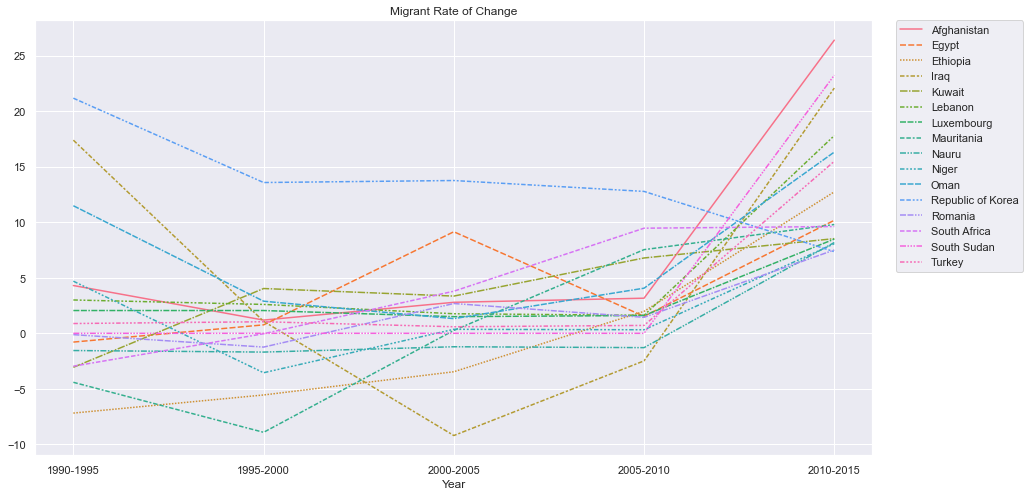

In [532]:
line1 = above_migrant.pivot("Year", "Major area, region, country or area of destination", "Migrant Rate of Change") 
line2 = above_refugee.pivot("Year", "Major area, region, country or area of destination", "Refugee Rate of Change")
line3 = rtm.pivot("Year", "Major area, region, country or area of destination", "Estimate")
sns.lineplot(data=line1).set_title("Migrant Rate of Change")
plt.legend(bbox_to_anchor=(1.18, 1), loc='upper right', borderaxespad=0)

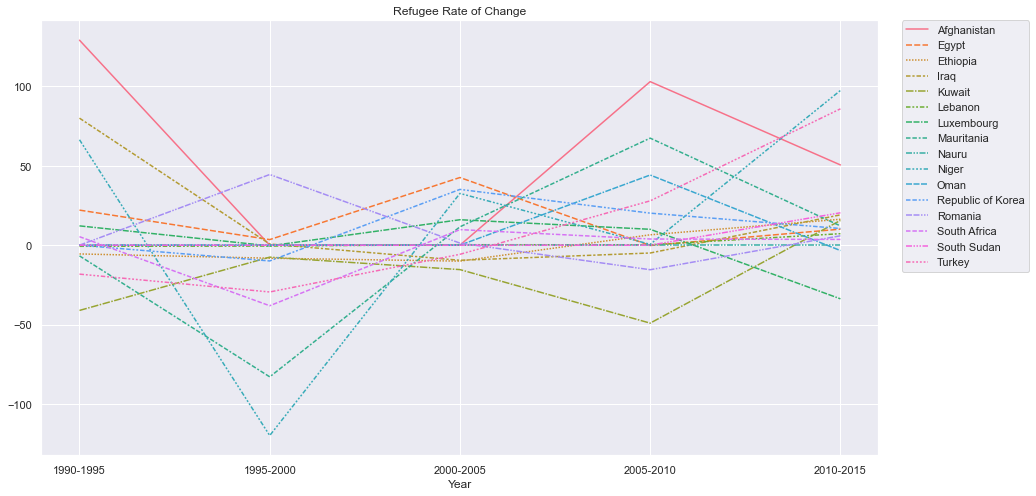

In [528]:
sns.lineplot(data=line2).set_title("Refugee Rate of Change")
plt.legend(bbox_to_anchor=(1.18, 1), loc='upper right', borderaxespad=0)


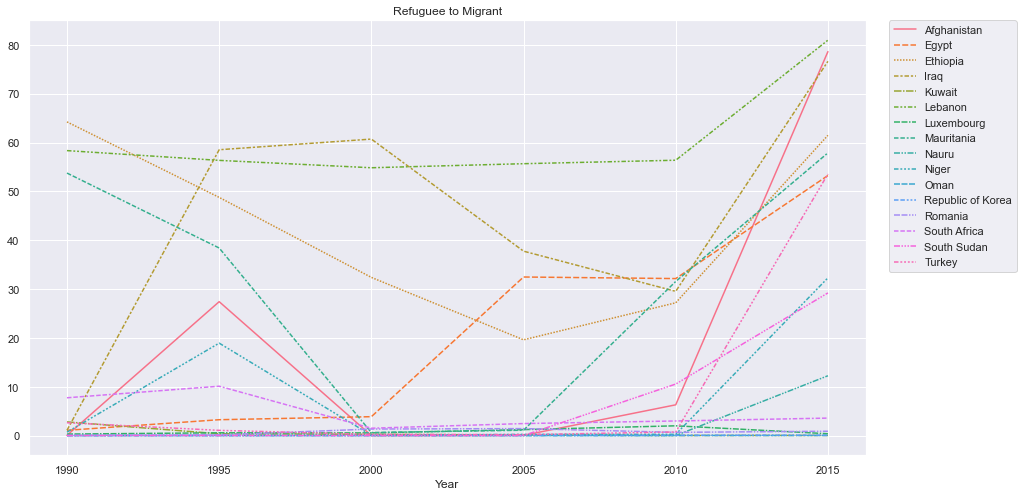

In [534]:
sns.lineplot(data=line3).set_title("Refuguee to Migrant")
plt.legend(bbox_to_anchor=(1.18, 1), loc='upper right', borderaxespad=0)